# 

# Environment Setup

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
from typing import List, Union, Tuple, Optional
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
from abc import abstractmethod

from boomspeaver.tools.data import get_repo_dir, load_numpy_file, save_numpy_file, pad_vector
from boomspeaver.tools.sampler import create_random_vector, shift_vector, mirror_vector
from boomspeaver.tools.dsp.dsp import fft_analysis, detect_peaks, get_resolution, detect_signal_bounds,calculate_spectrogram
from boomspeaver.tools.plot.configs import Axis, Line, Plotter, Points, Subplot
from boomspeaver.tools.plot.multi_plotter import MultiPlotter
from boomspeaver.tools.multiprocessing_runner import MultiprocessingRunner


In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Current CUDA device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch version: 2.5.1+cu121
CUDA available: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


# U-net

From [al4pde](https://github.com/dmusekamp/al4pde). Inside: Licensed under the MIT license. Adapted from [PDEArena](https://github.com/pdearena/pdearena).

In [4]:
# from pdearena.modules.activations import ACTIVATION_REGISTRY
# from pdearena.modules.conditioned.condition_utils import ConditionedBlock, fourier_embedding, zero_module

ACTIVATION_REGISTRY = {
    "relu": nn.ReLU(),
    "silu": nn.SiLU(),
    "gelu": nn.GELU(),
    "tanh": nn.Tanh(),
    "sigmoid": nn.Sigmoid(),
}

def fourier_embedding(timesteps: torch.Tensor, dim, max_period=10000):
    r"""Create sinusoidal timestep embeddings.

    Args:
        timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
        dim (int): the dimension of the output.
        max_period (int): controls the minimum frequency of the embeddings.
    Returns:
        embedding (torch.Tensor): [N $\times$ dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(
        device=timesteps.device
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class ConditionedBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """Apply the module to `x` given `emb` embdding of time or others."""

def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

In [5]:
def conv_layer(
    padding_mode: str, c_in: int, c_out: int, kernel_size: int, stride: int = 1, dilation: int = 1,
        padding: int = -1, n_dims: int = 1
):
    if padding < 0:
        padding = kernel_size // 2 if isinstance(kernel_size, int) else (kernel_size[0] // 2, kernel_size[1] // 2)
    if n_dims == 1:
        return nn.Conv1d(c_in, c_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation,
                         padding_mode=padding_mode)
    elif n_dims == 2:
        return nn.Conv2d(c_in, c_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation,
                         padding_mode=padding_mode)
    else:
        raise NotImplementedError(f"n_dims {n_dims} not implemented")


class ResidualBlock(ConditionedBlock):
    """Wide Residual Blocks used in modern Unet architectures.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        cond_channels (int): Number of channels in the conditioning vector.
        activation (str): Activation function to use.
        norm (bool): Whether to use normalization.
        n_groups (int): Number of groups for group normalization.
        use_scale_shift_norm (bool): Whether to use scale and shift approach to conditoning (also termed as `AdaGN`).
        n_dims (int): Number of spatial dimensions. Defaults to 1.
    """

    def __init__(
        self,
        padding_mode: str,
        in_channels: int,
        out_channels: int,
        cond_channels: int,
        activation: str = "gelu",
        norm: bool = False,
        n_groups: int = 1,
        use_scale_shift_norm: bool = False,
        n_dims: int = 1,
    ):
        super().__init__()
        self.use_scale_shift_norm = use_scale_shift_norm
        if activation == "gelu":
            self.activation = nn.GELU()
        elif activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "silu":
            self.activation = nn.SiLU()
        else:
            raise NotImplementedError(f"Activation {activation} not implemented")

        self.conv1 = conv_layer(padding_mode, in_channels, out_channels, kernel_size=3, n_dims=n_dims, )
        self.conv2 = zero_module(conv_layer(padding_mode, out_channels, out_channels, kernel_size=3, n_dims=n_dims))
        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = conv_layer(padding_mode, in_channels, out_channels, kernel_size=1, n_dims=n_dims)
        else:
            self.shortcut = nn.Identity()

        if norm:
            self.norm1 = nn.GroupNorm(n_groups, in_channels)
            self.norm2 = nn.GroupNorm(n_groups, out_channels)
        else:
            self.norm1 = nn.Identity()
            self.norm2 = nn.Identity()

        self.cond_emb = nn.Linear(cond_channels, 2 * out_channels if use_scale_shift_norm else out_channels)

    def forward(self, x: torch.Tensor, emb: torch.Tensor):
        # First convolution layer
        h = self.conv1(self.activation(self.norm1(x)))
        emb_out = self.cond_emb(emb)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = self.norm2(h) * (1 + scale) + shift  # where we do -1 or +1 doesn't matter
            h = self.conv2(self.activation(h))
        else:
            h = h + emb_out
            # Second convolution layer
            h = self.conv2(self.activation(self.norm2(h)))
        # Add the shortcut connection and return
        return h + self.shortcut(x)


class ConditionalResidualBlock(ConditionedBlock):
    """Wide Residual Blocks used in modern Unet architectures.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        cond_channels (int): Number of channels in the conditioning vector.
        activation (str): Activation function to use.
        norm (bool): Whether to use normalization.
        n_groups (int): Number of groups for group normalization.
        use_scale_shift_norm (bool): Whether to use scale and shift approach to conditoning (also termed as `AdaGN`).
        n_dims (int): Number of spatial dimensions. Defaults to 1.
    """

    def __init__(
        self,
        padding_mode: str,
        in_channels: int,
        out_channels: int,
        cond_channels_main: int,
        cond_channels_emb: int,
        activation: str = "gelu",
        norm: bool = False,
        n_groups: int = 1,
        use_scale_shift_norm: bool = False,
        n_dims: int = 1,
    ):
        super().__init__()
        self.use_scale_shift_norm = use_scale_shift_norm
        if activation == "gelu":
            self.activation = nn.GELU()
        elif activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "silu":
            self.activation = nn.SiLU()
        else:
            raise NotImplementedError(f"Activation {activation} not implemented")

        self.conv1 = conv_layer(padding_mode, in_channels + cond_channels_main, out_channels, kernel_size=3,
                                n_dims=n_dims)
        self.conv2 = zero_module(conv_layer(padding_mode, out_channels, out_channels, kernel_size=3, n_dims=n_dims))
        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = conv_layer(padding_mode, in_channels, out_channels, kernel_size=1, n_dims=n_dims)
        else:
            self.shortcut = nn.Identity()

        if norm:
            self.norm1 = nn.GroupNorm(n_groups, in_channels + cond_channels_main)
            self.norm2 = nn.GroupNorm(n_groups, out_channels)
        else:
            self.norm1 = nn.Identity()
            self.norm2 = nn.Identity()

        self.cond_emb = nn.Linear(cond_channels_emb, 2 * out_channels if use_scale_shift_norm else out_channels)

    def forward(self, x: torch.Tensor, emb: torch.Tensor, cond: torch.Tensor):
        # First convolution layer
        h = self.conv1(self.activation(self.norm1(torch.cat([x, cond], dim=1))))
        emb_out = self.cond_emb(emb)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = self.norm2(h) * (1 + scale) + shift  # where we do -1 or +1 doesn't matter
            h = self.conv2(self.activation(h))
        else:
            h = h + emb_out
            # Second convolution layer
            h = self.conv2(self.activation(self.norm2(h)))
        # Add the shortcut connection and return
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    """Attention block This is similar to [transformer multi-head
    attention](https://arxiv.org/abs/1706.03762).

    Args:
        n_channels: the number of channels in the input
        n_heads:  the number of heads in multi-head attention
        d_k: the number of dimensions in each head
        n_groups: the number of groups for [group normalization][torch.nn.GroupNorm]

    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: Optional[int] = None, n_groups: int = 1):
        """ """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k**-0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor):
        # Get shape
        orig_shape = x.shape
        if x.ndim == 3:
            x = x.unsqueeze(2)  # Pretend we have a height of 1 for 1D inputs
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum("bihd,bjhd->bijh", q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum("bijh,bjhd->bihd", attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(*orig_shape)
        return res

In [6]:
class DownBlock(ConditionedBlock):
    """Down block This combines `ResidualBlock` and `AttentionBlock`.

    These are used in the first half of U-Net at each resolution.

    Args:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        cond_channels (int): Number of channels in the conditioning vector.
        has_attn (bool): Whether to use attention block
        activation (nn.Module): Activation function
        norm (bool): Whether to use normalization
        use_scale_shift_norm (bool): Whether to use scale and shift approach to conditoning (also termed as `AdaGN`).
        n_dims (int): Number of spatial dimensions. Defaults to 1.
    """

    def __init__(
        self,
        padding_mode: str,
        in_channels: int,
        out_channels: int,
        cond_channels: int,
        has_attn: bool = False,
        activation: str = "gelu",
        norm: bool = False,
        use_scale_shift_norm: bool = False,
        n_dims: int = 1,
    ):
        super().__init__()
        self.res = ResidualBlock(
            padding_mode,
            in_channels,
            out_channels,
            cond_channels,
            activation=activation,
            norm=norm,
            use_scale_shift_norm=use_scale_shift_norm,
            n_dims=n_dims,
        )
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, emb: torch.Tensor):
        x = self.res(x, emb)
        x = self.attn(x)
        return x


class UpBlock(ConditionedBlock):
    """Up block This combines `ResidualBlock` and `AttentionBlock`.

    These are used in the second half of U-Net at each resolution.

    Args:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        cond_channels (int): Number of channels in the conditioning vector.
        has_attn (bool): Whether to use attention block
        activation (str): Activation function
        norm (bool): Whether to use normalization
        use_scale_shift_norm (bool): Whether to use scale and shift approach to conditoning (also termed as `AdaGN`).
        n_dims (int): Number of spatial dimensions. Defaults to 1.
    """

    def __init__(
        self,
        padding_mode: str,
        in_channels: int,
        out_channels: int,
        cond_channels: int,
        has_attn: bool = False,
        activation: str = "gelu",
        norm: bool = False,
        use_scale_shift_norm: bool = False,
        n_dims: int = 1,
    ):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(
            padding_mode,
            in_channels + out_channels,
            out_channels,
            cond_channels,
            activation=activation,
            norm=norm,
            use_scale_shift_norm=use_scale_shift_norm,
            n_dims=n_dims,
        )
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        x = self.res(x, emb)
        x = self.attn(x)
        return x


class MiddleBlock(ConditionedBlock):
    """Middle block It combines a `ResidualBlock`, `AttentionBlock`, followed by another
    `ResidualBlock`.

    This block is applied at the lowest resolution of the U-Net.

    Args:
        n_channels (int): Number of channels in the input and output.
        cond_channels (int): Number of channels in the conditioning vector.
        has_attn (bool, optional): Whether to use attention block. Defaults to False.
        activation (str): Activation function to use. Defaults to "gelu".
        norm (bool, optional): Whether to use normalization. Defaults to False.
        use_scale_shift_norm (bool, optional): Whether to use scale and shift approach to conditoning (also termed as `AdaGN`).
        n_dims (int): Number of spatial dimensions. Defaults to 1. Defaults to False.
    """

    def __init__(
        self,
        padding_mode: str,
        n_channels: int,
        cond_channels: int,
        has_attn: bool = False,
        activation: str = "gelu",
        norm: bool = False,
        use_scale_shift_norm: bool = False,
        n_dims: int = 1,
    ):
        super().__init__()
        self.res1 = ResidualBlock(
            padding_mode,
            n_channels,
            n_channels,
            cond_channels,
            activation=activation,
            norm=norm,
            use_scale_shift_norm=use_scale_shift_norm,
            n_dims=n_dims,
        )
        self.attn = AttentionBlock(n_channels) if has_attn else nn.Identity()
        self.res2 = ResidualBlock(
            padding_mode,
            n_channels,
            n_channels,
            cond_channels,
            activation=activation,
            norm=norm,
            use_scale_shift_norm=use_scale_shift_norm,
            n_dims=n_dims,
        )

    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        x = self.res1(x, emb)
        x = self.attn(x)
        x = self.res2(x, emb)
        return x


class Upsample(nn.Module):
    r"""Scale up the feature map by $2 \times$"""

    def __init__(self, padding_mode: str, n_channels: int, n_dims: int = 1):
        super().__init__()
        # only allows zero padding
        if n_dims == 1:
            self.conv = nn.ConvTranspose1d(n_channels, n_channels, 4, 2, 1,)
        elif n_dims == 2:
            self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1),)
        elif n_dims == 3:
            self.conv = nn.ConvTranspose3d(n_channels, n_channels, (4, 4, 4), (2, 2, 2),
                                           (1, 1, 1))
        else:
            raise ValueError(f"n_dims must be 1, 2, or 3, got {n_dims}")

    def forward(self, x: torch.Tensor):
        return self.conv(x)


class Downsample(nn.Module):
    r"""Scale down the feature map by $\frac{1}{2} \times$"""

    def __init__(self, padding_mode: str, n_channels: int, n_dims: int = 1):
        super().__init__()
        if n_dims == 1:
            self.conv = nn.Conv1d(n_channels, n_channels, 3, 2, 1, padding_mode=padding_mode)
        elif n_dims == 2:
            self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1),
                                  padding_mode=padding_mode)
        elif n_dims == 3:
            self.conv = nn.Conv3d(n_channels, n_channels, (3, 3, 3), (2, 2, 2), (1, 1, 1),
                                  padding_mode=padding_mode)
        else:
            raise ValueError(f"n_dims must be 1, 2, or 3, got {n_dims}")

    def forward(self, x: torch.Tensor):
        return self.conv(x)


class Unet1D(nn.Module):
    """Modern U-Net architecture

    This is a modern U-Net architecture with wide-residual blocks and spatial attention blocks

    Args:
        n_input_scalar_components (int): Number of scalar components in the model
        n_input_vector_components (int): Number of vector components in the model
        n_output_scalar_components (int): Number of output scalar components in the model
        n_output_vector_components (int): Number of output vector components in the model
        time_history (int): Number of time steps in the input
        time_future (int): Number of time steps in the output
        hidden_channels (int): Number of channels in the hidden layers
        activation (str): Activation function to use
        norm (bool): Whether to use normalization
        ch_mults (list): List of channel multipliers for each resolution
        is_attn (list): List of booleans indicating whether to use attention blocks
        mid_attn (bool): Whether to use attention block in the middle block
        n_blocks (int): Number of residual blocks in each resolution
        param_conditioning (Optional[str]): Type of conditioning to use. Defaults to None.
        use_scale_shift_norm (bool): Whether to use scale and shift approach to conditoning (also termed as `AdaGN`). Defaults to False.
        use1x1 (bool): Whether to use 1x1 convolutions in the initial and final layers.
        n_dims (int): Number of spatial dimensions. Defaults to 1.

    Note:
        Currently, only `scalar` parameter conditioning is supported.
    """

    def __init__(
        self,
        padding_mode: str,
        n_input_scalar_components: int,
        n_input_vector_components: int,
        n_output_scalar_components: int,
        n_output_vector_components: int,
        time_history,
        time_future,
        hidden_channels,
        activation,
        norm: bool = False,
        ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
        is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, False, False),
        mid_attn: bool = False,
        n_blocks: int = 2,
        param_conditioning: Optional[str] = None,
        use_scale_shift_norm: bool = False,
        use1x1: bool = False,
        n_dims: int = 1,
        features: str = "last_layer"
    ) -> None:
        super().__init__()
        self.n_input_scalar_components = n_input_scalar_components
        self.n_input_vector_components = n_input_vector_components
        self.n_output_scalar_components = n_output_scalar_components
        self.n_output_vector_components = n_output_vector_components
        self.time_history = time_history
        self.time_future = time_future
        self.hidden_channels = hidden_channels
        self.activation = activation
        self.n_dims = n_dims
        self.param_conditioning = param_conditioning
        self.activation: nn.Module = ACTIVATION_REGISTRY.get(activation, None)
        if features not in ["middle", "last_layer"]:
            raise ValueError(features)
        self.features = features
        if self.activation is None:
            raise NotImplementedError(f"Activation {activation} not implemented")

        # Number of resolutions
        n_resolutions = len(ch_mults)

        insize = time_history * (self.n_input_scalar_components + self.n_input_vector_components * 2)
        n_channels = hidden_channels
        time_embed_dim = hidden_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_channels, time_embed_dim),
            self.activation,
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        if self.param_conditioning is not None:
            if self.param_conditioning.startswith("scalar"):
                num_params = 1 if "_" not in self.param_conditioning else int(self.param_conditioning.split("_")[1])
                self.pde_emb = nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Linear(hidden_channels, time_embed_dim),
                            self.activation,
                            nn.Linear(time_embed_dim, time_embed_dim),
                        )
                        for _ in range(num_params)
                    ]
                )
            else:
                raise NotImplementedError(f"Param conditioning {self.param_conditioning} not implemented")
        self.param_use_time = False
        self.param_use_cond = False

        # Project image into feature map
        if use1x1:
            self.image_proj = conv_layer(padding_mode, insize, n_channels, kernel_size=1, n_dims=n_dims)
        else:
            self.image_proj = conv_layer(padding_mode, insize, n_channels, kernel_size=3, n_dims=n_dims)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(
                    DownBlock(
                        padding_mode,
                        in_channels,
                        out_channels,
                        time_embed_dim,
                        has_attn=is_attn[i],
                        activation=activation,
                        norm=norm,
                        use_scale_shift_norm=use_scale_shift_norm,
                        n_dims=n_dims,
                    )
                )
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(padding_mode, in_channels, n_dims=n_dims))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(
            padding_mode,
            out_channels,
            time_embed_dim,
            has_attn=mid_attn,
            activation=activation,
            norm=norm,
            use_scale_shift_norm=use_scale_shift_norm,
            n_dims=n_dims,
        )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(
                    UpBlock(
                        padding_mode,
                        in_channels,
                        out_channels,
                        time_embed_dim,
                        has_attn=is_attn[i],
                        activation=activation,
                        norm=norm,
                        use_scale_shift_norm=use_scale_shift_norm,
                        n_dims=n_dims,
                    )
                )
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(
                UpBlock(
                    padding_mode,
                    in_channels,
                    out_channels,
                    time_embed_dim,
                    has_attn=is_attn[i],
                    activation=activation,
                    norm=norm,
                    use_scale_shift_norm=use_scale_shift_norm,
                    n_dims=n_dims,
                )
            )
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(padding_mode, in_channels, n_dims=n_dims))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        if norm:
            self.norm = nn.GroupNorm(8, n_channels)
        else:
            self.norm = nn.Identity()
        out_channels = time_future * (self.n_output_scalar_components + self.n_output_vector_components * 2)
        if use1x1:
            self.final = zero_module(conv_layer(padding_mode, in_channels, out_channels, kernel_size=1, n_dims=n_dims))
        else:
            self.final = zero_module(conv_layer(padding_mode, in_channels, out_channels, kernel_size=3, n_dims=n_dims))

    def forward(self, x: torch.Tensor, time: torch.Tensor = None, z: torch.Tensor = None, return_features=False):
        assert x.dim() == 3 + self.n_dims
        assert not (time is None and z is None)
        orig_shape = x.shape
        x = x.reshape(x.size(0), -1, *x.shape[3:])  # collapse T,C

        emb = 0
        if time is not None:
            emb = emb + self.time_embed(fourier_embedding(time, self.hidden_channels))
            self.param_use_time = True
        else:
            assert not self.param_use_time, "Cannot pass time=None after using it in a previous forward pass"
        if z is not None:
            if self.param_conditioning.startswith("scalar"):
                if z.ndim == 1:
                    z = z[:, None]
                for i in range(z.shape[-1]):
                    emb = emb + self.pde_emb[i](fourier_embedding(z[..., i], self.hidden_channels))
            else:
                raise NotImplementedError(f"Param conditioning {self.param_conditioning} not implemented")
            self.param_use_cond = True
        else:
            assert not self.param_use_cond, "Cannot pass z=None after using it in a previous forward pass"

        x = self.image_proj(x)

        h = [x]
        for m in self.down:
            if isinstance(m, Downsample):
                x = m(x)
            else:
                x = m(x, emb)
            h.append(x)

        x = self.middle(x, emb)
        features = x
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, emb)
        last_act = self.activation(self.norm(x))
        if self.features == "last_layer":
            features = last_act
        x = self.final(last_act)
        res = x.reshape(
            orig_shape[0], -1, (self.n_output_scalar_components + self.n_output_vector_components * 2), *orig_shape[3:]
        )
        if return_features:
            return res, features.unsqueeze(1)
        return res

# Modification

Let's skip the resolution part for now and focus on the temporal aspect, using embedding-based conditioning. Initially, we should concentrate on the middle part of the U-Net, which enforces compression.

In [7]:
class MiddleBlock(ConditionedBlock):
    """Middle block It combines a `ResidualBlock`, `AttentionBlock`, followed by another
    `ResidualBlock`.

    This block is applied at the lowest resolution of the U-Net.

    Args:
        n_channels (int): Number of channels in the input and output.
        cond_channels (int): Number of channels in the conditioning vector.
        has_attn (bool, optional): Whether to use attention block. Defaults to False.
        activation (str): Activation function to use. Defaults to "gelu".
        norm (bool, optional): Whether to use normalization. Defaults to False.
        use_scale_shift_norm (bool, optional): Whether to use scale and shift approach to conditoning (also termed as `AdaGN`).
        n_dims (int): Number of spatial dimensions. Defaults to 1. Defaults to False.
    """

    def __init__(
        self,
        padding_mode: str,
        n_channels: int,
        cond_channels: int,
        has_attn: bool = False,
        activation: str = "gelu",
        norm: bool = False,
        use_scale_shift_norm: bool = False,
        n_dims: int = 1,
    ):
        super().__init__()
        self.res1 = ResidualBlock(
            padding_mode,
            n_channels,
            n_channels,
            cond_channels,
            activation=activation,
            norm=norm,
            use_scale_shift_norm=use_scale_shift_norm,
            n_dims=n_dims,
        )
        self.attn = AttentionBlock(n_channels) if has_attn else nn.Identity()
        self.res2 = ResidualBlock(
            padding_mode,
            n_channels,
            n_channels,
            cond_channels,
            activation=activation,
            norm=norm,
            use_scale_shift_norm=use_scale_shift_norm,
            n_dims=n_dims,
        )

    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        x = self.res1(x, emb)
        x = self.attn(x)
        x = self.res2(x, emb)
        return x

## Simple test

In [8]:
# Instantiate the MiddleBlock
middle = MiddleBlock(
    padding_mode='zeros',
    n_channels=8,
    cond_channels=4,
    has_attn=True,
    activation="gelu",
    norm=True,
    use_scale_shift_norm=True,
    n_dims=1,
)

In [9]:
batch_size = 2
length = 64
x = torch.randn(batch_size, 8, length)        # input signal
emb = torch.randn(batch_size, 4)              # conditioning (e.g., time embedding)

In [10]:
out = middle(x, emb)
print(out.shape)  # Expected: (2, 8, 64)

torch.Size([2, 8, 64])


In [11]:
target = torch.randn_like(out)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(middle.parameters(), lr=1e-3)

for epoch in range(100):
    optimizer.zero_grad()
    output = middle(x, emb)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 2.1554
Epoch 10: Loss = 1.9721
Epoch 20: Loss = 1.8373
Epoch 30: Loss = 1.7112
Epoch 40: Loss = 1.5709
Epoch 50: Loss = 1.4338
Epoch 60: Loss = 1.3098
Epoch 70: Loss = 1.1997
Epoch 80: Loss = 1.1026
Epoch 90: Loss = 1.0149


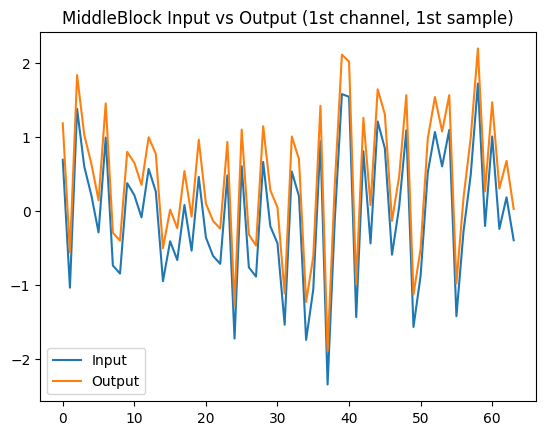

In [12]:
plt.plot(x[0, 0].detach().numpy(), label="Input")
plt.plot(out[0, 0].detach().numpy(), label="Output")
plt.title("MiddleBlock Input vs Output (1st channel, 1st sample)")
plt.legend()
plt.show()

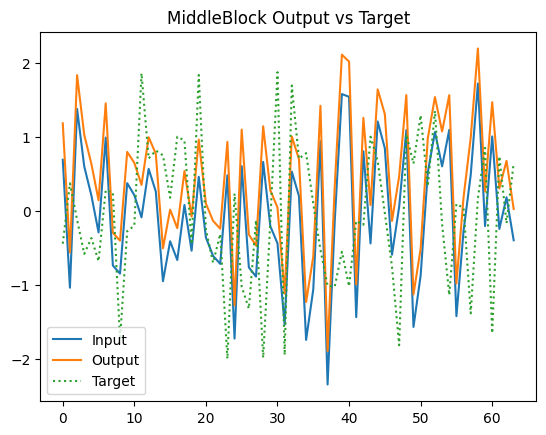

In [13]:
# === Visualize Result ===
i = 0  # example from batch
plt.plot(x[i][0].detach(), label="Input")
plt.plot(out[i][0].detach(), label="Output")
plt.plot(target[i][0].detach(), label="Target", linestyle="dotted")
plt.title("MiddleBlock Output vs Target")
plt.legend()
plt.show()

# Generate dataset

In [14]:
repo_dir=get_repo_dir(run_type="python")
input_time_path = repo_dir / "examples/time_vector_10ms_48kHz.npy"
loudspeaker_param_path = repo_dir / "examples/prv_audio_6MB400_8ohm.json"
# mic_signal_path_fast=repo_dir / "output/wave_equation_default_cosine.npy"

In [15]:
!cd "$repo_dir"
!pwd

/home/freetzz/repo/ls_wip/loudspeaker-solver


## Check fenics

In [16]:
!docker compose up -d

[+] Running 0/1
 ⠋ Container fenics  Starting                                              0.1s 
[+] Running 0/1
 ⠙ Container fenics  Starting                                              0.2s 
[+] Running 1/1
 ✔ Container fenics  Started                                               0.3s 


In [17]:
!./run_fenics.sh -c boomspeaver/acoustic/the_membrane.py --initial_condition_path examples/cosine_wave.npy

Real mode
Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00203359s, CPU 0.001124s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 14.8002s, CPU 14.6135s)
Info    : 221179 nodes 442360 elements
Info    : Writing 'output/annulus.msh'...
Info    : Done writing 'output/annulus.msh'
Info    : Reading 'output/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     
Info    : Done reading 'output/annulus.msh'                                                                      
2.083333333333

To make sure that we won't miss any frequency, we should provide domain resolution: "At least 10–20 nodes per wavelength of the smallest (highest frequency) wave you want to resolve." Formula to calculate wavelength: `λₘᵢₙ = v / fₘₐₓ`.

### Initial membrane condition
Let's generate some random initial membrane conditions. Membrane is represented by 128 points. Scaled to 0 displacement on edges.

In [18]:
# n_points=[128, 64, 32, 16]
n_points=[128]
value_range=(-1.0, 1.0)
n_samples=20000
output_dir_name="output_surrogate"

In [19]:
def random_diaphragm_sample(output_dir: Path, n_samples: int, n_points: int, value_range: tuple[float, float], seed: int = 42) -> None:
    assert isinstance(output_dir, Path) and output_dir.exists()
    assert isinstance(n_points, int)
    assert isinstance(n_samples, int)
    assert isinstance(value_range, tuple)

    rng = np.random.default_rng(seed=seed)
    output_paths=[]
    for i in range(n_samples):
        output_path=output_dir / f"membrane_{i}.npy"
        output_paths.append(output_path)
        v = create_random_vector(n_points, rng=rng, value_range=value_range)
        v_shift = shift_vector(v, to_idx=-1, to_val=0.0)
        # v_mirror = mirror_vector(v_shift)
        # save_numpy_file(output_path=output_path, data=v_shift)
    return output_paths

In [20]:
membrane_paths=[]
for i in n_points:
    # output_dir = repo_dir / output_dir_name / f"dataset_first_{i}"
    output_dir = repo_dir / output_dir_name / f"dataset_first_256"
    # output_dir.mkdir(parents=True, exist_ok=False)
    output_dir.mkdir(parents=True, exist_ok=True)
    output_dir = output_dir.relative_to(repo_dir)

    membrane_paths_ = random_diaphragm_sample(
        output_dir=output_dir,
        n_samples=n_samples,
        n_points=i,
        value_range=value_range,
        )
    membrane_paths+=membrane_paths_

In [21]:
print(len(membrane_paths))

20000


### Simulate

In [22]:
def run_simulation(membrane_path):
    output_path = membrane_path.with_suffix("") / f"{membrane_path.stem}_simulated.xdmf"
    if not output_path.with_suffix(".npy").exists():
        cmd = [
            "./run_fenics.sh",
            "-c", "boomspeaver/acoustic/the_membrane.py",
            "--initial_condition_path", str(membrane_path),
            "--output_path", str(output_path),
            "--listen"
        ]
        subprocess.run(cmd, check=True)
        # TODO only temporary for saving only numpy arrays
        # Safe cleanup with checks
        for path in [
            output_path,
            output_path.with_suffix(".h5"),
            output_path.parent / "annulus.msh",
        ]:
            try:
                if path.exists():
                    subprocess.run(["docker", "exec", "fenics", "rm", "-rf", str(path)], check=False)
            except Exception as e:
                print(f"[WARN] Could not remove {path}: {e}")

In [ ]:
runner = MultiprocessingRunner(run_simulation, membrane_paths, num_workers=18)
# runner = MultiprocessingRunner(run_simulation, membrane_paths, num_workers=6)
runner.run()

Processing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00554828s, CPU 0.002269s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00295817s, CPU 0.002826s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Info    : Done meshing 2D (Wall 29.2025s, CPU 27.9716s)
Info    : 221179 nodes 442360 elements
Info    : Done meshing 2D (Wall 28.7895s, CPU 28.0084s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12624/annulus.msh'...
Info    : Writing 'output_surrogate/dataset_first_256/membrane_14787/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14787/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14787/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12624/annulus.msh'                           


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12624/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                        


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14787/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12624/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416


419 0.008729166666666666 0
420 0.008749999999999999 0
421 0.008770833333333334 0
422 0.008791666666666666 0
423 0.0088125 0
424 0.008833333333333334 0
425 0.008854166666666666 0
426 0.008875 0
427 0.008895833333333334 0
428 0.008916666666666666 0
429 0.0089375 0
430 0.008958333333333334 0
431 0.008979166666666667 0
432 0.009 0
433 0.009020833333333334 0
434 0.009041666666666667 0
435 0.0090625 0
436 0.009083333333333334 0
437 0.009104166666666667 0
438 0.009125 0
439 0.009145833333333332 0
440 0.009166666666666667 0
441 0.0091875 0
442 0.009208333333333332 0
443 0.009229166666666667 0
444 0.00925 0
445 0.009270833333333332 0
446 0.009291666666666667 0
447 0.0093125 0
448 0.009333333333333332 0
449 0.009354166666666667 0
450 0.009375 0
451 0.009395833333333332 0
452 0.009416666666666667 0
453 0.0094375 0
454 0.009458333333333332 0
455 0.009479166666666667 0
456 0.0095 0
457 0.009520833333333333 0
458 0.009541666666666667 0
459 0.0095625 0
460 0.009583333333333333 0
461 0.00960416666666

Real mode
Real mode


ng curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00265797s, CPU 0.002575s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00238076s, CPU 0.002059s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Writing 'output_surrogate/dataset_first_256/membrane_10136/annulus.msh'...
Info    : Writing 'output_surrogate/dataset_first_256/membrane_12073/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10136/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10136/annulus.msh'...
Info    : 5 entities


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10136/annulus.msh'                           
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12073/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Done meshing 2D (Wall 29.5086s, CPU 28.3515s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10413/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10413/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10413/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10413/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

833333333333 0
164 0.0034166666666666664 0
165 0.0034375 0
166 0.0034583333333333332 0
167 0.0034791666666666664 0
168 0.0035 0
169 0.0035208333333333333 0
170 0.0035416666666666665 0
171 0.0035624999999999997 0
172 0.0035833333333333333 0
173 0.0036041666666666665 0
174 0.0036249999999999998 0
175 0.0036458333333333334 0
176 0.0036666666666666666 0
177 0.0036875 0
178 0.003708333333333333 0
179 0.0037291666666666667 0
180 0.00375 0
181 0.003770833333333333 0
182 0.0037916666666666667 0
183 0.0038125 0
184 0.003833333333333333 0
185 0.0038541666666666663 0
186 0.003875 0
187 0.003895833333333333 0
188 0.003916666666666666 0
189 0.0039375 0
190 0.003958333333333333 0
191 0.0039791666666666664 0
192 0.004 0
193 0.004020833333333333 0
194 0.0040416666666666665 0
195 0.0040625 0
196 0.004083333333333333 0
197 0.0041041666666666666 0
198 0.004125 0
199 0.004145833333333333 0
200 0.004166666666666667 0
201 0.0041875 0
202 0.004208333333333333 0
203 0.004229166666666667 0
204 0.00424999999999

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00273699s, CPU 0.002677s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00219354s, CPU 0.001229s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 27.2376s, CPU 26.6576s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11245/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11245/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11245/annulus.msh'...
Info    : 5 entities


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11245/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 29.2597s, CPU 28.6639s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13681/annulus.msh'...


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13681/annulus.msh'
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333

Real mode
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0023223s, CPU 0.002242s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00677347s, CPU 0.002776s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 27.2176s, CPU 26.6892s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13407/annulus.msh'...
Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.00070833333

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 28.2015s, CPU 27.4159s)
Info    : 221179 nodes 442360 elements


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13407/annulus.msh'
Info    : Writing 'output_surrogate/dataset_first_256/membrane_12349/annulus.msh'...
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13407/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13407/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12349/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12349/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12349/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode
Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshi

ng curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00256666s, CPU 0.002524s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.002694s, CPU 0.002617s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 26.3315s, CPU 25.8704s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13956/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13956/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13956/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00248645s, CPU 0.002434s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13956/annulus.msh'


Info    : Done meshing 2D (Wall 27.3411s, CPU 25.7596s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10691/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10691/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10691/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10691/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0025483s, CPU 0.00243s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00331703s, CPU 0.003174s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 26.1692s, CPU 25.5882s)


Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13129/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13129/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13129/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13129/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 28.7545s, CPU 27.8137s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14234/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14234/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14234/annulus.msh'                           


Info    : Done meshing 2D (Wall 29.0656s, CPU 28.4208s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14511/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14511/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14511/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14511/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00255168s, CPU 0.002502s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00313677s, CPU 0.00305s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00319495s, CPU 0.002231s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00245351s, CPU 0.002388s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.6768s, CPU 27.9489s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11523/annulus.msh'...


Info    : Done meshing 2D (Wall 29.9732s, CPU 29.2151s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11801/annulus.msh'...


Info    : Done meshing 2D (Wall 26.0882s, CPU 25.1989s)
Info    : 221179 nodes 442360 elements


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11523/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11523/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10966/annulus.msh'...


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11523/annulus.msh'                           
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11801/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11801/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10966/annulus.msh'                           


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10966/annulus.msh'...                             
Info    : 5 entities
Info    : 221179 nodes
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11801/annulus.msh'                           


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10966/annulus.msh'                           


5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 29.4395s, CPU 28.77s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12853/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12853/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12853/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12853/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00280684s, CPU 0.00248s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00292536s, CPU 0.002927s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 27.8844s, CPU 27.3197s)
Info    : 221179 nodes 442360 elements


Info    : Done meshing 2D (Wall 29.1143s, CPU 28.4069s)
Info    : 221179 nodes 442360 elements
Info    : Writing 'output_surrogate/dataset_first_256/membrane_14788/annulus.msh'...


Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : 221179 nodes
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14788/annulus.msh'                           


Real mode [ 90%] Reading elements                                                                                
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12625/annulus.msh'


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00299861s, CPU 0.002896s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00248013s, CPU 0.002429s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 26.2192s, CPU 25.6938s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10137/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10137/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10137/annulus.msh'...


Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10137/annulus.msh'                           


Info    : Done meshing 2D (Wall 29.727s, CPU 29.193s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12074/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12074/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12074/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12074/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00197915s, CPU 0.001983s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 25.6772s, CPU 25.0698s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10414/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10414/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10414/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10414/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

833333333333 0
164 0.0034166666666666664 0
165 0.0034375 0
166 0.0034583333333333332 0
167 0.0034791666666666664 0
168 0.0035 0
169 0.0035208333333333333 0
170 0.0035416666666666665 0
171 0.0035624999999999997 0
172 0.0035833333333333333 0
173 0.0036041666666666665 0
174 0.0036249999999999998 0
175 0.0036458333333333334 0
176 0.0036666666666666666 0
177 0.0036875 0
178 0.003708333333333333 0
179 0.0037291666666666667 0
180 0.00375 0
181 0.003770833333333333 0
182 0.0037916666666666667 0
183 0.0038125 0
184 0.003833333333333333 0
185 0.0038541666666666663 0
186 0.003875 0
187 0.003895833333333333 0
188 0.003916666666666666 0
189 0.0039375 0
190 0.003958333333333333 0
191 0.0039791666666666664 0
192 0.004 0
193 0.004020833333333333 0
194 0.0040416666666666665 0
195 0.0040625 0
196 0.004083333333333333 0
197 0.0041041666666666666 0
198 0.004125 0
199 0.004145833333333333 0
200 0.004166666666666667 0
201 0.0041875 0
202 0.004208333333333333 0
203 0.004229166666666667 0
204 0.00424999999999

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00324641s, CPU 0.003221s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00549303s, CPU 0.002489s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 25.6562s, CPU 24.9985s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11246/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11246/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11246/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11246/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Done meshing 2D (Wall 26.4391s, CPU 25.6657s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13682/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13682/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13682/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13682/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00288843s, CPU 0.00279s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0029139s, CPU 0.002859s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 25.6739s, CPU 25.131s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12350/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12350/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Writing 'output_surrogate/dataset_first_256/membrane_13408/annulus.msh'...


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12350/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13408/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13408/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Real mode [ 90%] Reading nodes                                                                                
Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13408/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00230105s, CPU 0.002242s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0029346s, CPU 0.002366s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00277952s, CPU 0.00267s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10692/annulus.msh'...


Info    : Done meshing 2D (Wall 25.8443s, CPU 25.1833s)
Info    : 221179 nodes 442360 elements


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10692/annulus.msh'
Info    : Writing 'output_surrogate/dataset_first_256/membrane_13957/annulus.msh'...


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10692/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10692/annulus.msh'                           


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13957/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13957/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13957/annulus.msh'


Info    : Done meshing 2D (Wall 28.3159s, CPU 27.6694s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13130/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13130/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13130/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                       


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0024527s, CPU 0.002454s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14235/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14235/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14235/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14235/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00295866s, CPU 0.002961s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00221139s, CPU 0.00219s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.2564s, CPU 27.7069s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14512/annulus.msh'...


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14512/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14512/annulus.msh'                           


Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00239159s, CPU 0.002396s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00330713s, CPU 0.003245s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 25.9092s, CPU 25.2518s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11524/annulus.msh'...


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11524/annulus.msh'                           
Info    : Done meshing 2D (Wall 28.2167s, CPU 27.4246s)


Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10967/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10967/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10967/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10967/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 27.9898s, CPU 27.2624s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12854/annulus.msh'...


Info    : Done meshing 2D (Wall 26.6538s, CPU 25.7759s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11802/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12854/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12854/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11802/annulus.msh'                           
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11802/annulus.msh'...                             
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12854/annulus.msh'                           


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11802/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00208947s, CPU 0.00202s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00246137s, CPU 0.002415s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 25.787s, CPU 25.2671s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14789/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14789/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14789/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : Done meshing 2D (Wall 29.4241s, CPU 28.9559s)
Info    : 221179 nodes 442360 elements                                                                           


Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12626/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12626/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12626/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00312977s, CPU 0.003046s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.8668s, CPU 29.1053s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12075/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12075/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12075/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12075/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 29.3772s, CPU 28.7254s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10138/annulus.msh'...
Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10138/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10138/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10138/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Done meshing 2D (Wall 29.107s, CPU 28.5427s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10415/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10415/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10415/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10415/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00190753s, CPU 0.00191s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0015964s, CPU 0.001599s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.105s, CPU 27.827s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11247/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11247/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11247/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done meshing 2D (Wall 25.5536s, CPU 25.1767s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13683/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13683/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13683/annulus.msh'...
Info    : 5 entities


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13683/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00231991s, CPU 0.002204s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00272312s, CPU 0.002589s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 26.4267s, CPU 25.7067s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12351/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12351/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12351/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12351/annulus.msh'                           


Info    : Done meshing 2D (Wall 24.9097s, CPU 24.3981s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13409/annulus.msh'...


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13409/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00398152s, CPU 0.003204s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00233995s, CPU 0.002266s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0033758s, CPU 0.002543s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 27.4375s, CPU 26.9582s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10693/annulus.msh'...


Info    : Done meshing 2D (Wall 29.0062s, CPU 28.259s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13958/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10693/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10693/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13958/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10693/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13958/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13958/annulus.msh'


Info    : Done meshing 2D (Wall 27.0142s, CPU 26.3042s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13131/annulus.msh'...


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13131/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13131/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00310268s, CPU 0.003038s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333

6666666666 0
378 0.007875 0
379 0.007895833333333333 0
380 0.007916666666666666 0
381 0.0079375 0
382 0.007958333333333333 0
383 0.007979166666666666 0
384 0.008 0
385 0.008020833333333333 0
386 0.008041666666666666 0
387 0.0080625 0
388 0.008083333333333333 0
389 0.008104166666666666 0
390 0.008125 0
391 0.008145833333333333 0
392 0.008166666666666666 0
393 0.0081875 0
394 0.008208333333333333 0
395 0.008229166666666666 0
396 0.00825 0
397 0.008270833333333333 0
398 0.008291666666666666 0
399 0.0083125 0
400 0.008333333333333333 0
401 0.008354166666666666 0
402 0.008375 0
403 0.008395833333333333 0
404 0.008416666666666666 0
405 0.0084375 0
406 0.008458333333333333 0
407 0.008479166666666666 0
408 0.008499999999999999 0
409 0.008520833333333333 0
410 0.008541666666666666 0
411 0.008562499999999999 0
412 0.008583333333333333 0
413 0.008604166666666666 0
414 0.008624999999999999 0
415 0.008645833333333333 0
416 0.008666666666666666 0
417 0.008687499999999999 0
418 0.008708333333333334 0

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00308376s, CPU 0.003086s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 27.1312s, CPU 26.6384s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14236/annulus.msh'...
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0

Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14236/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14236/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14236/annulus.msh'


Info    : Done meshing 2D (Wall 26.395s, CPU 25.554s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14513/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0021262s, CPU 0.002058s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14513/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14513/annulus.msh'...


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14513/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00262127s, CPU 0.002495s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.002058s, CPU 0.002052s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 29.8601s, CPU 28.8214s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11525/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00195543s, CPU 0.00191s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11525/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11525/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11525/annulus.msh'                           


Info    : Done meshing 2D (Wall 25.5191s, CPU 24.9592s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10968/annulus.msh'...


Info    : Done meshing 2D (Wall 26.9522s, CPU 26.1551s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11803/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10968/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10968/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10968/annulus.msh'                           


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11803/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11803/annulus.msh'...
Info    : 5 entities


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11803/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 27.9567s, CPU 27.4362s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12855/annulus.msh'...


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12855/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00239092s, CPU 0.002301s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00268912s, CPU 0.001696s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 29.952s, CPU 29.2603s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14790/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14790/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14790/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14790/annulus.msh'                           


Info    : Done meshing 2D (Wall 25.6402s, CPU 25.0583s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12627/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12627/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12627/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12627/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...ence                                                                                                                    
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)                                                                   
Info    : Done meshing 1D (Wall 0.00274869s, CPU 0.002516s)                                                                                    
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Meshing 1D...                                                         
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00270472s, CPU 0.002636s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 25.3525s, CPU 24.7971s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10139/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10139/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10139/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00359282s, CPU 0.003491s)                                                      
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10139/annulus.msh'                           
Info    : Done meshing 2D (Wall 29.7321s, CPU 28.8978s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12076/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12076/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12076/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12076/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 30.2028s, CPU 29.5609s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10416/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10416/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10416/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00332271s, CPU 0.003058s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 29.9407s, CPU 29.1505s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13684/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13684/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13684/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13684/annulus.msh'


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11248/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11248/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11248/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11248/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0020554s, CPU 0.002049s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00315792s, CPU 0.002953s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 26.5954s, CPU 24.9306s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13410/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13410/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13410/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13410/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 26.9945s, CPU 26.0959s)
Info    : 221179 nodes 442360 elements


Real mode
Info    : Writing 'output_surrogate/dataset_first_256/membrane_12352/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12352/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12352/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12352/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00198196s, CPU 0.001802s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00624698s, CPU 0.002245s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.5218s, CPU 28.006s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10694/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00245063s, CPU 0.002341s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10694/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10694/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10694/annulus.msh'                           


Info    : Done meshing 2D (Wall 29.9564s, CPU 28.8808s)
Info    : 221179 nodes 442360 elements
Info    : Done meshing 2D (Wall 27.1573s, CPU 26.2858s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13959/annulus.msh'...


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13132/annulus.msh'...


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13132/annulus.msh'...                          
Info    : 5 entities
Info    : 221179 nodes


0.007020833333333333 0ng elements                                                                                
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.00777083333333

Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13959/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13132/annulus.msh'


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00311158s, CPU 0.003049s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00310484s, CPU 0.003096s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 29.4144s, CPU 28.7522s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14237/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14237/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14237/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00314014s, CPU 0.003043s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14237/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 30.1173s, CPU 29.2017s)
Info    : 221179 nodes 442360 elements


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00576155s, CPU 0.002748s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Writing 'output_surrogate/dataset_first_256/membrane_14514/annulus.msh'...


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

031666666666666666 0
153 0.0031875 0
154 0.0032083333333333334 0
155 0.0032291666666666666 0
156 0.00325 0
157 0.003270833333333333 0
158 0.0032916666666666667 0
159 0.0033125 0
160 0.003333333333333333 0
161 0.0033541666666666668 0
162 0.003375 0
163 0.003395833333333333 0
164 0.0034166666666666664 0
165 0.0034375 0
166 0.0034583333333333332 0
167 0.0034791666666666664 0
168 0.0035 0
169 0.0035208333333333333 0
170 0.0035416666666666665 0
171 0.0035624999999999997 0
172 0.0035833333333333333 0
173 0.0036041666666666665 0
174 0.0036249999999999998 0
175 0.0036458333333333334 0
176 0.0036666666666666666 0
177 0.0036875 0
178 0.003708333333333333 0
179 0.0037291666666666667 0
180 0.00375 0
181 0.003770833333333333 0
182 0.0037916666666666667 0
183 0.0038125 0
184 0.003833333333333333 0
185 0.0038541666666666663 0
186 0.003875 0
187 0.003895833333333333 0
188 0.003916666666666666 0
189 0.0039375 0
190 0.003958333333333333 0
191 0.0039791666666666664 0
192 0.004 0
193 0.004020833333333333 

6666666666 0
378 0.007875 0
379 0.007895833333333333 0
380 0.007916666666666666 0
381 0.0079375 0
382 0.007958333333333333 0
383 0.007979166666666666 0
384 0.008 0
385 0.008020833333333333 0
386 0.008041666666666666 0
387 0.0080625 0
388 0.008083333333333333 0
389 0.008104166666666666 0
390 0.008125 0
391 0.008145833333333333 0
392 0.008166666666666666 0
393 0.0081875 0
394 0.008208333333333333 0
395 0.008229166666666666 0
396 0.00825 0
397 0.008270833333333333 0
398 0.008291666666666666 0
399 0.0083125 0
400 0.008333333333333333 0
401 0.008354166666666666 0
402 0.008375 0
403 0.008395833333333333 0
404 0.008416666666666666 0
405 0.0084375 0
406 0.008458333333333333 0
407 0.008479166666666666 0
408 0.008499999999999999 0
409 0.008520833333333333 0
410 0.008541666666666666 0
411 0.008562499999999999 0
412 0.008583333333333333 0
413 0.008604166666666666 0
414 0.008624999999999999 0
415 0.008645833333333333 0
416 0.008666666666666666 0
417 0.008687499999999999 0
418 0.008708333333333334 0

Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14514/annulus.msh'


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00269293s, CPU 0.00262s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00316848s, CPU 0.00315s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.9303s, CPU 29.4059s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11526/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11526/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11526/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11526/annulus.msh'                           


Info    : Done meshing 2D (Wall 28.5138s, CPU 27.1111s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11804/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11804/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11804/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11804/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 30.4069s, CPU 29.5572s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10969/annulus.msh'...


Info    : Done meshing 2D (Wall 27.525s, CPU 26.9398s)
Info    : 221179 nodes 442360 elements


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10969/annulus.msh'
Info    : Writing 'output_surrogate/dataset_first_256/membrane_12856/annulus.msh'...


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10969/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10969/annulus.msh'


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12856/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12856/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12856/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00389634s, CPU 0.003847s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00249914s, CPU 0.002433s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 28.582s, CPU 27.77s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14791/annulus.msh'...


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14791/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14791/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     
0.007020833333333333 0ng elements                                                                                
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.00766666666666

Real mode [ 40%] Reading elements                                                                                


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00264331s, CPU 0.002533s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00178818s, CPU 0.00179s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 27.272s, CPU 26.5754s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12628/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12628/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12628/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12628/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode
Info    : Done meshing 2D (Wall 24.7077s, CPU 24.225s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10140/annulus.msh'...


Info    : Done meshing 2D (Wall 27.8766s, CPU 27.1037s)
Info    : 221179 nodes 442360 elements


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10140/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10140/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes
Info    : Writing 'output_surrogate/dataset_first_256/membrane_12077/annulus.msh'...                          


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10140/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00260814s, CPU 0.002444s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12077/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12077/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12077/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Info    : Done meshing 2D (Wall 29.5986s, CPU 28.8776s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10417/annulus.msh'...


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10417/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0030263s, CPU 0.002957s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

66666666666 0
198 0.004125 0
199 0.004145833333333333 0
200 0.004166666666666667 0
201 0.0041875 0
202 0.004208333333333333 0
203 0.004229166666666667 0
204 0.0042499999999999994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239

Info    : Done meshing 2D (Wall 25.7746s, CPU 25.2303s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13685/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13685/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13685/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13685/annulus.msh'


Info    : Done meshing 2D (Wall 26.8253s, CPU 26.4672s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11249/annulus.msh'...


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11249/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00333289s, CPU 0.003249s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00171456s, CPU 0.001717s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

666666 0
81 0.0016875 0
82 0.0017083333333333332 0
83 0.0017291666666666666 0
84 0.00175 0
85 0.0017708333333333332 0
86 0.0017916666666666667 0
87 0.0018124999999999999 0
88 0.0018333333333333333 0
89 0.0018541666666666665 0
90 0.001875 0
91 0.0018958333333333334 0
92 0.0019166666666666666 0
93 0.0019375 0
94 0.001958333333333333 0
95 0.0019791666666666664 0
96 0.002 0
97 0.0020208333333333332 0
98 0.0020416666666666665 0
99 0.0020625 0
100 0.0020833333333333333 0
101 0.0021041666666666665 0
102 0.0021249999999999997 0
103 0.0021458333333333334 0
104 0.0021666666666666666 0
105 0.0021874999999999998 0
106 0.0022083333333333334 0
107 0.0022291666666666666 0
108 0.00225 0
109 0.0022708333333333335 0
110 0.0022916666666666667 0
111 0.0023125 0
112 0.002333333333333333 0
113 0.0023541666666666667 0
114 0.002375 0
115 0.002395833333333333 0
116 0.002416666666666667 0
117 0.0024375 0
118 0.002458333333333333 0
119 0.0024791666666666664 0
120 0.0025 0
121 0.0025208333333333333 0
122 0.002541

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0029643s, CPU 0.002965s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 27.2815s, CPU 26.6867s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13411/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13411/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13411/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13411/annulus.msh'                           


Info    : Done meshing 2D (Wall 26.5228s, CPU 25.7918s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12353/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12353/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12353/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12353/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00297967s, CPU 0.00292s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.77s, CPU 27.9967s)
Info    : 221179 nodes 442360 elements


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00351873s, CPU 0.003465s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Writing 'output_surrogate/dataset_first_256/membrane_10695/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10695/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10695/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10695/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Done meshing 2D (Wall 24.9245s, CPU 24.4624s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13960/annulus.msh'...


Info    : Done meshing 2D (Wall 29.2772s, CPU 28.6917s)
Info    : 221179 nodes 442360 elements
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13960/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13960/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : Writing 'output_surrogate/dataset_first_256/membrane_13133/annulus.msh'...                          


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13960/annulus.msh'                           


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13133/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13133/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13133/annulus.msh'


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00267502s, CPU 0.002595s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00271015s, CPU 0.002613s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00246063s, CPU 0.002463s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00252166s, CPU 0.002281s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 27.0497s, CPU 26.0822s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14238/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14238/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14238/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 26.1368s, CPU 25.461s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11805/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11805/annulus.msh'
Info    : Done meshing 2D (Wall 27.1432s, CPU 26.3343s)
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11805/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 221179 nodes 442360 elements                                                                        


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14515/annulus.msh'...                             


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11805/annulus.msh'                           


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14515/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14515/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14515/annulus.msh'
Info    : Done meshing 2D (Wall 28.6267s, CPU 27.959s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11527/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11527/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11527/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11527/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0030633s, CPU 0.00298s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0021998s, CPU 0.001998s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.7148s, CPU 29.1314s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10970/annulus.msh'...


Info    : Done meshing 2D (Wall 27.5602s, CPU 26.9849s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12857/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10970/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12857/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10970/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12857/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12857/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00292173s, CPU 0.002661s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416


187 0.003895833333333333 0
188 0.003916666666666666 0
189 0.0039375 0
190 0.003958333333333333 0
191 0.0039791666666666664 0
192 0.004 0
193 0.004020833333333333 0
194 0.0040416666666666665 0
195 0.0040625 0
196 0.004083333333333333 0
197 0.0041041666666666666 0
198 0.004125 0
199 0.004145833333333333 0
200 0.004166666666666667 0
201 0.0041875 0
202 0.004208333333333333 0
203 0.004229166666666667 0
204 0.0042499999999999994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 

Real mode


8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00182759s, CPU 0.00183s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 27.2306s, CPU 26.5713s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14792/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14792/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14792/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14792/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00244934s, CPU 0.002207s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.0737s, CPU 28.429s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12629/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12629/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12629/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12629/annulus.msh'                           


Info    : Done meshing 2D (Wall 27.9591s, CPU 27.5366s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10141/annulus.msh'...


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10141/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10141/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10141/annulus.msh'


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00275914s, CPU 0.001595s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.7816s, CPU 28.7475s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12078/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12078/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12078/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12078/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Writing 'output_surrogate/dataset_first_256/membrane_10418/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10418/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10418/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10418/annulus.msh'                           


99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00200383s, CPU 0.002005s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00678218s, CPU 0.002782s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.1751s, CPU 28.584s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11250/annulus.msh'...


Info    : Done meshing 2D (Wall 27.0228s, CPU 26.2568s)
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11250/annulus.msh'
Info    : 221179 nodes 442360 elements


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11250/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     
Info    : Writing 'output_surrogate/dataset_first_256/membrane_13686/annulus.msh'...                             


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11250/annulus.msh'


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13686/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13686/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13686/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00252211s, CPU 0.002399s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00225263s, CPU 0.001963s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Info    : Done meshing 2D (Wall 28.6571s, CPU 27.8404s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12354/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12354/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12354/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12354/annulus.msh'                           


Info    : Done meshing 2D (Wall 26.2238s, CPU 25.7621s)
Info    : 221179 nodes 442360 elements


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 


419 0.008729166666666666 0
420 0.008749999999999999 0
421 0.008770833333333334 0
422 0.008791666666666666 0
423 0.0088125 0
424 0.008833333333333334 0
425 0.008854166666666666 0
426 0.008875 0
427 0.008895833333333334 0
428 0.008916666666666666 0
429 0.0089375 0
430 0.008958333333333334 0
431 0.008979166666666667 0
432 0.009 0
433 0.009020833333333334 0
434 0.009041666666666667 0
435 0.0090625 0
436 0.009083333333333334 0
437 0.009104166666666667 0
438 0.009125 0
439 0.009145833333333332 0
440 0.009166666666666667 0
441 0.0091875 0
442 0.009208333333333332 0
443 0.009229166666666667 0
444 0.00925 0
445 0.009270833333333332 0
446 0.009291666666666667 0
447 0.0093125 0
448 0.009333333333333332 0
449 0.009354166666666667 0
450 0.009375 0
451 0.009395833333333332 0
452 0.009416666666666667 0
453 0.0094375 0
454 0.009458333333333332 0
455 0.009479166666666667 0
456 0.0095 0
457 0.009520833333333333 0
458 0.009541666666666667 0
459 0.0095625 0
460 0.009583333333333333 0
461 0.00960416666666

Info    : 221179 nodes


Real mode [ 90%] Reading nodes                                                                                
Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13412/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0025662s, CPU 0.002435s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00296161s, CPU 0.002793s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00216722s, CPU 0.002106s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Info    : Done meshing 2D (Wall 26.3857s, CPU 25.8102s)
Info    : 221179 nodes 442360 elements


Info    : Done meshing 2D (Wall 28.5015s, CPU 27.6165s)
Info    : 221179 nodes 442360 elements
Info    : Writing 'output_surrogate/dataset_first_256/membrane_13961/annulus.msh'...


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10696/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13961/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13961/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10696/annulus.msh'                        
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10696/annulus.msh'...                          
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elementsnodes                                                                                


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13961/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10696/annulus.msh'                           


Info    : Done meshing 2D (Wall 29.5044s, CPU 28.8047s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13134/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13134/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13134/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13134/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00233061s, CPU 0.002238s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00327461s, CPU 0.002136s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00402715s, CPU 0.003641s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Done meshing 2D (Wall 28.8882s, CPU 27.4401s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14239/annulus.msh'...


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Reading 'output_surrogate/dataset_first_256/membrane_14239/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00207157s, CPU 0.002065s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14239/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 29.245s, CPU 28.2359s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11806/annulus.msh'...


Info    : Done meshing 2D (Wall 25.9306s, CPU 25.4364s)
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
3

6667 0
462 0.009625 0
463 0.009645833333333333 0
464 0.009666666666666667 0
465 0.0096875 0
466 0.009708333333333333 0
467 0.009729166666666665 0
468 0.00975 0
469 0.009770833333333333 0
470 0.009791666666666666 0
471 0.0098125 0
472 0.009833333333333333 0
473 0.009854166666666666 0
474 0.009875 0
475 0.009895833333333333 0
476 0.009916666666666666 0
477 0.0099375 0
478 0.009958333333333333 0
479 0.009979166666666666 0
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11528/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11806/annulus.msh'
Real mode


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11806/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11806/annulus.msh'                           
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11528/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11528/annulus.msh'


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.003644s, CPU 0.003647s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 27.5705s, CPU 26.876s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14516/annulus.msh'...


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14516/annulus.msh'


Real mode
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14516/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14516/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00226274s, CPU 0.002193s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 29.2116s, CPU 28.5962s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10971/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10971/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10971/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10971/annulus.msh'


Info    : Done meshing 2D (Wall 27.2202s, CPU 26.4373s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12858/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12858/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12858/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12858/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00302564s, CPU 0.003025s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00330428s, CPU 0.003307s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00285871s, CPU 0.002639s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00215494s, CPU 0.002139s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 26.5202s, CPU 25.7496s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14793/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14793/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14793/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14793/annulus.msh'


Info    : Done meshing 2D (Wall 27.2777s, CPU 26.5595s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10142/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10142/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10142/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10142/annulus.msh'                           


Info    : Done meshing 2D (Wall 27.2875s, CPU 26.6579s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12630/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12630/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12630/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12630/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 29.9828s, CPU 29.3703s)
Info    : 221179 nodes 442360 elements


Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12079/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00238883s, CPU 0.00141s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 28.5044s, CPU 27.8799s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10419/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10419/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10419/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10419/annulus.msh'                           


5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0046826s, CPU 0.003266s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 27.3749s, CPU 26.7587s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13687/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13687/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13687/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13687/annulus.msh'                           


Info    : Done meshing 2D (Wall 26.3179s, CPU 25.6525s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11251/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11251/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11251/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11251/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00299233s, CPU 0.002995s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00271331s, CPU 0.002639s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

833333333333 0
164 0.0034166666666666664 0
165 0.0034375 0
166 0.0034583333333333332 0
167 0.0034791666666666664 0
168 0.0035 0
169 0.0035208333333333333 0
170 0.0035416666666666665 0
171 0.0035624999999999997 0
172 0.0035833333333333333 0
173 0.0036041666666666665 0
174 0.0036249999999999998 0
175 0.0036458333333333334 0
176 0.0036666666666666666 0
177 0.0036875 0
178 0.003708333333333333 0
179 0.0037291666666666667 0
180 0.00375 0
181 0.003770833333333333 0
182 0.0037916666666666667 0
183 0.0038125 0
184 0.003833333333333333 0
185 0.0038541666666666663 0
186 0.003875 0
187 0.003895833333333333 0
188 0.003916666666666666 0
189 0.0039375 0
190 0.003958333333333333 0
191 0.0039791666666666664 0
192 0.004 0
193 0.004020833333333333 0
194 0.0040416666666666665 0
195 0.0040625 0
196 0.004083333333333333 0
197 0.0041041666666666666 0
198 0.004125 0
199 0.004145833333333333 0
200 0.004166666666666667 0
201 0.0041875 0
202 0.004208333333333333 0
203 0.004229166666666667 0
204 0.00424999999999

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

833333333333 0
164 0.0034166666666666664 0
165 0.0034375 0
166 0.0034583333333333332 0
167 0.0034791666666666664 0
168 0.0035 0
169 0.0035208333333333333 0
170 0.0035416666666666665 0
171 0.0035624999999999997 0
172 0.0035833333333333333 0
173 0.0036041666666666665 0
174 0.0036249999999999998 0
175 0.0036458333333333334 0
176 0.0036666666666666666 0
177 0.0036875 0
178 0.003708333333333333 0
179 0.0037291666666666667 0
180 0.00375 0
181 0.003770833333333333 0
182 0.0037916666666666667 0
183 0.0038125 0
184 0.003833333333333333 0
185 0.0038541666666666663 0
186 0.003875 0
187 0.003895833333333333 0
188 0.003916666666666666 0
189 0.0039375 0
190 0.003958333333333333 0
191 0.0039791666666666664 0
192 0.004 0
193 0.004020833333333333 0
194 0.0040416666666666665 0
195 0.0040625 0
196 0.004083333333333333 0
197 0.0041041666666666666 0
198 0.004125 0
199 0.004145833333333333 0
200 0.004166666666666667 0
201 0.0041875 0
202 0.004208333333333333 0
203 0.004229166666666667 0
204 0.00424999999999

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00286241s, CPU 0.002865s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.5477s, CPU 27.8845s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12355/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12355/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13413/annulus.msh'...                             


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12355/annulus.msh'                           


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13413/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13413/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13413/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00476513s, CPU 0.002705s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.4307s, CPU 27.4151s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10697/annulus.msh'...


Info    : Done meshing 2D (Wall 28.3429s, CPU 27.6307s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13135/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10697/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10697/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13135/annulus.msh'
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10697/annulus.msh'                           
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13135/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13135/annulus.msh'                           


Info    : Done meshing 2D (Wall 25.1306s, CPU 24.5315s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13962/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13962/annulus.msh'


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13962/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00190747s, CPU 0.001805s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00232215s, CPU 0.002235s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 29.8605s, CPU 28.8178s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14240/annulus.msh'...


Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14240/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14240/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14240/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0030601s, CPU 0.003055s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 26.6854s, CPU 25.9062s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11529/annulus.msh'...


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00290515s, CPU 0.002863s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11529/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11529/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11529/annulus.msh'


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00229372s, CPU 0.002191s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 27.2348s, CPU 26.7044s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11807/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11807/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11807/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11807/annulus.msh'


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00228879s, CPU 0.002192s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 26.6019s, CPU 25.785s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10972/annulus.msh'...


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10972/annulus.msh'


Info    : Done meshing 2D (Wall 29.8745s, CPU 29.1024s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14517/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14517/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14517/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14517/annulus.msh'


Info    : Done meshing 2D (Wall 29.3742s, CPU 28.8478s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12859/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12859/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12859/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12859/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode
Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00213898s, CPU 0.002072s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00259622s, CPU 0.002526s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 26.8005s, CPU 26.0926s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14794/annulus.msh'...


Info    : Done meshing 2D (Wall 30.5504s, CPU 29.6162s)
Info    : 221179 nodes 442360 elements


Info    : Done meshing 2D (Wall 30.2897s, CPU 28.9587s)
Info    : 221179 nodes 442360 elements
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14794/annulus.msh'
Info    : Writing 'output_surrogate/dataset_first_256/membrane_10143/annulus.msh'...


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14794/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12631/annulus.msh'...


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14794/annulus.msh'                           


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10143/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10143/annulus.msh'...
Info    : 5 entities


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12631/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                        


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10143/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12631/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 29.7282s, CPU 28.8871s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12080/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00284303s, CPU 0.002615s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12080/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 26.0146s, CPU 25.3678s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10420/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10420/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10420/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00235513s, CPU 0.002296s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00281387s, CPU 0.00267s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 26.8252s, CPU 26.3069s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11252/annulus.msh'...


Info    : Done meshing 2D (Wall 26.887s, CPU 26.1047s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13688/annulus.msh'...                          
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11252/annulus.msh'


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13688/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13688/annulus.msh'...
Info    : 5 entities


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13688/annulus.msh'                           


8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00470342s, CPU 0.002923s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00288049s, CPU 0.002756s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 26.0296s, CPU 25.1924s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12356/annulus.msh'...


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416


419 0.008729166666666666 0
420 0.008749999999999999 0
421 0.008770833333333334 0
422 0.008791666666666666 0
423 0.0088125 0
424 0.008833333333333334 0
425 0.008854166666666666 0
426 0.008875 0
427 0.008895833333333334 0
428 0.008916666666666666 0
429 0.0089375 0
430 0.008958333333333334 0
431 0.008979166666666667 0
432 0.009 0
433 0.009020833333333334 0
434 0.009041666666666667 0
435 0.0090625 0
436 0.009083333333333334 0
437 0.009104166666666667 0
438 0.009125 0
439 0.009145833333333332 0
440 0.009166666666666667 0
441 0.0091875 0
442 0.009208333333333332 0
443 0.009229166666666667 0
444 0.00925 0
445 0.009270833333333332 0
446 0.009291666666666667 0
447 0.0093125 0
448 0.009333333333333332 0
449 0.009354166666666667 0
450 0.009375 0
451 0.009395833333333332 0
452 0.009416666666666667 0
453 0.0094375 0
454 0.009458333333333332 0
455 0.009479166666666667 0
456 0.0095 0
457 0.009520833333333333 0
458 0.009541666666666667 0
459 0.0095625 0
460 0.009583333333333333 0
461 0.00960416666666

Real mode
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12356/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12356/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Real mode [  0%] Reading nodes                                                                                


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12356/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00301794s, CPU 0.003019s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00439746s, CPU 0.003111s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00292708s, CPU 0.002875s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 30.0936s, CPU 29.2315s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13414/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13414/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13414/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13414/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 27.621s, CPU 26.6969s)
Info    : 221179 nodes 442360 elements


Info    : Done meshing 2D (Wall 28.071s, CPU 27.4348s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10698/annulus.msh'...


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13136/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10698/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10698/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13136/annulus.msh'                           


Info    : Done meshing 2D (Wall 26.6346s, CPU 26.1397s)                                                          
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13136/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 221179 nodes 442360 elements                                                                           


Info    : 442358 elements                                                                                        


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10698/annulus.msh'


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13963/annulus.msh'...                             


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13136/annulus.msh'                           


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13963/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13963/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13963/annulus.msh'                           


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00309559s, CPU 0.003086s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Done meshing 2D (Wall 27.1173s, CPU 26.2141s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14241/annulus.msh'...


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14241/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Info    : Done meshing 2D (Wall 29.59s, CPU 28.8805s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11530/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11530/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11530/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11530/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.00

Real mode
Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333

666666 0
81 0.0016875 0
82 0.0017083333333333332 0
83 0.0017291666666666666 0
84 0.00175 0
85 0.0017708333333333332 0
86 0.0017916666666666667 0
87 0.0018124999999999999 0
88 0.0018333333333333333 0
89 0.0018541666666666665 0
90 0.001875 0
91 0.0018958333333333334 0
92 0.0019166666666666666 0
93 0.0019375 0
94 0.001958333333333333 0
95 0.0019791666666666664 0
96 0.002 0
97 0.0020208333333333332 0
98 0.0020416666666666665 0
99 0.0020625 0
100 0.0020833333333333333 0
101 0.0021041666666666665 0
102 0.0021249999999999997 0
103 0.0021458333333333334 0
104 0.0021666666666666666 0
105 0.0021874999999999998 0
106 0.0022083333333333334 0
107 0.0022291666666666666 0
108 0.00225 0
109 0.0022708333333333335 0
110 0.0022916666666666667 0
111 0.0023125 0
112 0.002333333333333333 0
113 0.0023541666666666667 0
114 0.002375 0
115 0.002395833333333333 0
116 0.002416666666666667 0
117 0.0024375 0
118 0.002458333333333333 0
119 0.0024791666666666664 0
120 0.0025 0
121 0.0025208333333333333 0
122 0.002541

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0022983s, CPU 0.002265s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 25.9952s, CPU 25.1044s)
Info    : 221179 nodes 442360 elements
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.0077708333

Info    : Writing 'output_surrogate/dataset_first_256/membrane_11808/annulus.msh'...


Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11808/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11808/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11808/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00277481s, CPU 0.002686s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.1104s, CPU 28.5732s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14518/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14518/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14518/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14518/annulus.msh'                           


Info    : Done meshing 2D (Wall 28.0718s, CPU 27.4307s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10973/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10973/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10973/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10973/annulus.msh'


Info    : Done meshing 2D (Wall 27.3546s, CPU 26.7269s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12860/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12860/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12860/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12860/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00427704s, CPU 0.002595s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00326311s, CPU 0.003041s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00262569s, CPU 0.002488s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 27.5859s, CPU 26.4817s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10144/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10144/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10144/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00221514s, CPU 0.002139s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Writing 'output_surrogate/dataset_first_256/membrane_12632/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12632/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12632/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done meshing 2D (Wall 29.0273s, CPU 28.3653s)                                                          
Info    : 221179 nodes 442360 elements


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12632/annulus.msh'


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14795/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14795/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14795/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00242151s, CPU 0.00231s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.1323s, CPU 27.2868s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12081/annulus.msh'...


Info    : 442358 elements                                                                                     


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 29.6389s, CPU 28.3778s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10421/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10421/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10421/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10421/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00237785s, CPU 0.002283s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00285774s, CPU 0.002787s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.6557s, CPU 27.6825s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13689/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13689/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13689/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13689/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 28.0222s, CPU 27.1582s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11253/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11253/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11253/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11253/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0020405s, CPU 0.001979s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00212046s, CPU 0.002073s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.2187s, CPU 27.427s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12357/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12357/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12357/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12357/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

.002395833333333333 0
116 0.002416666666666667 0
117 0.0024375 0
118 0.002458333333333333 0
119 0.0024791666666666664 0
120 0.0025 0
121 0.0025208333333333333 0
122 0.0025416666666666665 0
123 0.0025625 0
124 0.0025833333333333333 0
125 0.0026041666666666665 0
126 0.0026249999999999997 0
127 0.0026458333333333334 0
128 0.0026666666666666666 0
129 0.0026875 0
130 0.0027083333333333334 0
131 0.0027291666666666666 0
132 0.00275 0
133 0.002770833333333333 0
134 0.0027916666666666667 0
135 0.0028125 0
136 0.002833333333333333 0
137 0.0028541666666666667 0
138 0.002875 0
139 0.002895833333333333 0
140 0.0029166666666666664 0
141 0.0029375 0
142 0.002958333333333333 0
143 0.0029791666666666664 0
144 0.003 0
145 0.0030208333333333333 0
146 0.0030416666666666665 0
147 0.0030624999999999997 0
148 0.0030833333333333333 0
149 0.0031041666666666665 0
150 0.0031249999999999997 0
151 0.0031458333333333334 0
152 0.0031666666666666666 0
153 0.0031875 0
154 0.0032083333333333334 0
155 0.0032291666666666

Real mode


Info    : Done meshing 2D (Wall 27.1162s, CPU 26.3373s)
Info    : 221179 nodes 442360 elements
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.0077708333

Info    : Writing 'output_surrogate/dataset_first_256/membrane_13415/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0021792s, CPU 0.001983s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13415/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13415/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                       


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00281544s, CPU 0.002818s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00249593s, CPU 0.002376s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 29.0412s, CPU 28.5291s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10699/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10699/annulus.msh'


Info    : 442358 elements                                                       


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13137/annulus.msh'...                             


Info    : Done meshing 2D (Wall 29.7539s, CPU 28.7857s)                                                          
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10699/annulus.msh'
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13964/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13137/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13137/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13964/annulus.msh'                        


Info    : 442358 elements                                                                                     
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13964/annulus.msh'...                             
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                        


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13137/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13964/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00194885s, CPU 0.001952s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 28.3754s, CPU 27.2833s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14242/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14242/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14242/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14242/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00279002s, CPU 0.002727s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0024831s, CPU 0.002411s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00228004s, CPU 0.002197s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.7591s, CPU 27.837s)
Info    : 221179 nodes 442360 elements


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Writing 'output_surrogate/dataset_first_256/membrane_11531/annulus.msh'...


Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11531/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11531/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11531/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0027118s, CPU 0.002669s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 30.0562s, CPU 29.5671s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11809/annulus.msh'...


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 30.1131s, CPU 29.3693s)
Info    : 221179 nodes 442360 elements


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11809/annulus.msh'
Real mode
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11809/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : Writing 'output_surrogate/dataset_first_256/membrane_10974/annulus.msh'...                          


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11809/annulus.msh'                           


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10974/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10974/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10974/annulus.msh'


Info    : Done meshing 2D (Wall 26.4662s, CPU 25.8652s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14519/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00315469s, CPU 0.003139s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14519/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14519/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14519/annulus.msh'


Info    : Done meshing 2D (Wall 29.1188s, CPU 28.409s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12861/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12861/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12861/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12861/annulus.msh'                           


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00311331s, CPU 0.003005s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00221639s, CPU 0.002138s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


666666 0
81 0.0016875 0
82 0.0017083333333333332 0
83 0.0017291666666666666 0
84 0.00175 0
85 0.0017708333333333332 0
86 0.0017916666666666667 0
87 0.0018124999999999999 0
88 0.0018333333333333333 0
89 0.0018541666666666665 0
90 0.001875 0
91 0.0018958333333333334 0
92 0.0019166666666666666 0
93 0.0019375 0
94 0.001958333333333333 0
95 0.0019791666666666664 0
96 0.002 0
97 0.0020208333333333332 0
98 0.0020416666666666665 0
99 0.0020625 0
100 0.0020833333333333333 0
101 0.0021041666666666665 0
102 0.0021249999999999997 0
103 0.0021458333333333334 0
104 0.0021666666666666666 0
105 0.0021874999999999998 0
106 0.0022083333333333334 0
107 0.0022291666666666666 0
108 0.00225 0
109 0.0022708333333333335 0
110 0.0022916666666666667 0
111 0.0023125 0
112 0.002333333333333333 0
113 0.0023541666666666667 0
114 0.002375 0
115 0.002395833333333333 0
116 0.002416666666666667 0
117 0.0024375 0
118 0.002458333333333333 0
119 0.0024791666666666664 0
120 0.0025 0
121 0.0025208333333333333 0
122 0.002541

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00225096s, CPU 0.002172s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 30.9137s, CPU 29.1387s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10145/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10145/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10145/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10145/annulus.msh'


Info    : Done meshing 2D (Wall 30.0038s, CPU 27.9034s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12633/annulus.msh'...


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12633/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12633/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     
Real mode [  0%] Reading elements                                                                                


Sensitivity: 93.1 dBding elements                                                                                
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.000

666666 0
81 0.0016875 0
82 0.0017083333333333332 0
83 0.0017291666666666666 0
84 0.00175 0
85 0.0017708333333333332 0
86 0.0017916666666666667 0
87 0.0018124999999999999 0
88 0.0018333333333333333 0
89 0.0018541666666666665 0
90 0.001875 0
91 0.0018958333333333334 0
92 0.0019166666666666666 0
93 0.0019375 0
94 0.001958333333333333 0
95 0.0019791666666666664 0
96 0.002 0
97 0.0020208333333333332 0
98 0.0020416666666666665 0
99 0.0020625 0
100 0.0020833333333333333 0
101 0.0021041666666666665 0
102 0.0021249999999999997 0
103 0.0021458333333333334 0
104 0.0021666666666666666 0
105 0.0021874999999999998 0
106 0.0022083333333333334 0
107 0.0022291666666666666 0
108 0.00225 0
109 0.0022708333333333335 0
110 0.0022916666666666667 0
111 0.0023125 0
112 0.002333333333333333 0
113 0.0023541666666666667 0
114 0.002375 0
115 0.002395833333333333 0
116 0.002416666666666667 0
117 0.0024375 0
118 0.002458333333333333 0
119 0.0024791666666666664 0
120 0.0025 0
121 0.0025208333333333333 0
122 0.002541

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00259908s, CPU 0.002326s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 28.2302s, CPU 27.3639s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14796/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14796/annulus.msh'
Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00231058s, CPU 0.002208s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14796/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14796/annulus.msh'                           


Info    : Done meshing 2D (Wall 27.5481s, CPU 26.5307s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12082/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12082/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12082/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12082/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 28.555s, CPU 27.6686s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10422/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10422/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10422/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00223024s, CPU 0.00127s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00255903s, CPU 0.002559s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 27.2974s, CPU 26.6118s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13690/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13690/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13690/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Sensitivity: 93.1 dBding elements                                                                                
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.000

07916666666666666 0
39 0.0008125 0
40 0.0008333333333333333 0
41 0.0008541666666666666 0
42 0.000875 0
43 0.0008958333333333333 0
44 0.0009166666666666666 0
45 0.0009375 0
46 0.0009583333333333333 0
47 0.0009791666666666666 0
48 0.001 0
49 0.0010208333333333332 0
50 0.0010416666666666667 0
51 0.0010624999999999999 0
52 0.0010833333333333333 0
53 0.0011041666666666667 0
54 0.001125 0
55 0.0011458333333333333 0
56 0.0011666666666666665 0
57 0.0011875 0
58 0.0012083333333333334 0
59 0.0012291666666666666 0
60 0.00125 0
61 0.0012708333333333332 0
62 0.0012916666666666667 0
63 0.0013124999999999999 0
64 0.0013333333333333333 0
65 0.0013541666666666667 0
66 0.001375 0
67 0.0013958333333333333 0
68 0.0014166666666666666 0
69 0.0014375 0
70 0.0014583333333333332 0
71 0.0014791666666666666 0
72 0.0015 0
73 0.0015208333333333332 0
74 0.0015416666666666667 0
75 0.0015624999999999999 0
76 0.0015833333333333333 0
77 0.0016041666666666667 0
78 0.001625 0
79 0.0016458333333333333 0
80 0.0016666666666

Info    : Done meshing 2D (Wall 27.2544s, CPU 26.7483s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11254/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11254/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11254/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11254/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00218851s, CPU 0.002062s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00216828s, CPU 0.002152s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 31.3275s, CPU 30.0955s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12358/annulus.msh'...


0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
288 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 

Info    : Reading 'output_surrogate/dataset_first_256/membrane_12358/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Real mode [ 40%] Reading elements                                                                                


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12358/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0033698s, CPU 0.002992s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.7437s, CPU 28.7236s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13416/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00237279s, CPU 0.002291s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13416/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13416/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13416/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 27.929s, CPU 26.9564s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13965/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13965/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13965/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13965/annulus.msh'


Info    : Done meshing 2D (Wall 27.9498s, CPU 27.2297s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13138/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13138/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13138/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done meshing 2D (Wall 29.952s, CPU 29.1151s)                                                           
Info    : 221179 nodes 442360 elements                                                                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13138/annulus.msh'


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10700/annulus.msh'...


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10700/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0030125s, CPU 0.003012s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 26.0605s, CPU 25.5063s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14243/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14243/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14243/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00384364s, CPU 0.003782s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00247582s, CPU 0.002363s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00297174s, CPU 0.002079s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00230944s, CPU 0.002202s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.0768s, CPU 27.4164s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11532/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11532/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11532/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11532/annulus.msh'


Info    : Done meshing 2D (Wall 29.8382s, CPU 28.8727s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11810/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11810/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11810/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done meshing 2D (Wall 28.5366s, CPU 27.1184s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14520/annulus.msh'...


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14520/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : Done meshing 2D (Wall 29.8982s, CPU 29.1244s)                                                       
Info    : 221179 nodes 442360 elements


Info    : 442358 elements                                                                                     


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10975/annulus.msh'...                             


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14520/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10975/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10975/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements


Real mode
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10975/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00280301s, CPU 0.002621s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

6667 0
462 0.009625 0
463 0.009645833333333333 0
464 0.009666666666666667 0
465 0.0096875 0
466 0.009708333333333333 0
467 0.009729166666666665 0
468 0.00975 0
469 0.009770833333333333 0
470 0.009791666666666666 0
471 0.0098125 0
472 0.009833333333333333 0
473 0.009854166666666666 0
474 0.009875 0
475 0.009895833333333333 0
476 0.009916666666666666 0
477 0.0099375 0
478 0.009958333333333333 0
479 0.009979166666666666 0


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00268972s, CPU 0.002692s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 29.3831s, CPU 28.5326s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12862/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12862/annulus.msh'
Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshi

Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12862/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Info    : Done meshing 2D (Wall 28.8198s, CPU 27.8157s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10146/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10146/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10146/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10146/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 30.5486s, CPU 29.9589s)
Info    : 221179 nodes 442360 elements


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00318121s, CPU 0.003085s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12634/annulus.msh'...


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12634/annulus.msh'
Real mode


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12634/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12634/annulus.msh'


5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00211946s, CPU 0.002061s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00247971s, CPU 0.002427s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 30.0622s, CPU 28.4618s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12083/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12083/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12083/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12083/annulus.msh'


Info    : Done meshing 2D (Wall 30.4801s, CPU 29.1903s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14797/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14797/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14797/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14797/annulus.msh'                           


Info    : Done meshing 2D (Wall 27.5684s, CPU 26.4592s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10423/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10423/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10423/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10423/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00263784s, CPU 0.002383s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00299875s, CPU 0.003003s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 29.4493s, CPU 28.631s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13691/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13691/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13691/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements
Sensitivity: 93.1 dBding elements                                                                                
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666

Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13691/annulus.msh'                           


Info    : Done meshing 2D (Wall 27.2225s, CPU 26.533s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11255/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11255/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11255/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11255/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00254412s, CPU 0.002456s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00303429s, CPU 0.001976s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00169778s, CPU 0.001622s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 28.8662s, CPU 28.3916s)
Info    : 221179 nodes 442360 elements


5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12359/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12359/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12359/annulus.msh'
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333

6666666666 0
378 0.007875 0
379 0.007895833333333333 0
380 0.007916666666666666 0
381 0.0079375 0
382 0.007958333333333333 0
383 0.007979166666666666 0
384 0.008 0
385 0.008020833333333333 0
386 0.008041666666666666 0
387 0.0080625 0
388 0.008083333333333333 0
389 0.008104166666666666 0
390 0.008125 0
391 0.008145833333333333 0
392 0.008166666666666666 0
393 0.0081875 0
394 0.008208333333333333 0
395 0.008229166666666666 0
396 0.00825 0
397 0.008270833333333333 0
398 0.008291666666666666 0
399 0.0083125 0
400 0.008333333333333333 0
401 0.008354166666666666 0
402 0.008375 0
403 0.008395833333333333 0
404 0.008416666666666666 0
405 0.0084375 0
406 0.008458333333333333 0
407 0.008479166666666666 0
408 0.008499999999999999 0
409 0.008520833333333333 0
410 0.008541666666666666 0
411 0.008562499999999999 0
412 0.008583333333333333 0
413 0.008604166666666666 0
414 0.008624999999999999 0
415 0.008645833333333333 0
416 0.008666666666666666 0
417 0.008687499999999999 0
418 0.008708333333333334 0

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 27.3754s, CPU 26.6396s)
Info    : 221179 nodes 442360 elements


Real mode


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13417/annulus.msh'...


Info    : Done meshing 2D (Wall 28.1677s, CPU 27.0075s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13966/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00273521s, CPU 0.002681s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13417/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13417/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13417/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13966/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elementsce                                                                                   
Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00374338s, CPU 0.003632s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13966/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Info    : Done meshing 2D (Wall 28.8083s, CPU 27.924s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13139/annulus.msh'...


Info    : Done meshing 2D (Wall 27.5932s, CPU 26.9275s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10701/annulus.msh'...
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13139/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13139/annulus.msh'


Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10701/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00275431s, CPU 0.001769s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 27.5752s, CPU 26.9775s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14244/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14244/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14244/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14244/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode
0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00364297s, CPU 0.003465s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00262378s, CPU 0.002624s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00380141s, CPU 0.003803s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.2826s, CPU 27.1915s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11811/annulus.msh'...


Info    : Done meshing 2D (Wall 27.7878s, CPU 27.0651s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11533/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11811/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_11811/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11533/annulus.msh'                           


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11533/annulus.msh'...                             
Info    : 5 entities
Info    : 221179 nodes
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11811/annulus.msh'                        


Info    : 442358 elements                                                       


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11533/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 25.2137s, CPU 24.7161s)
Info    : 221179 nodes 442360 elements


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00256573s, CPU 0.002528s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14521/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14521/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14521/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14521/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00260326s, CPU 0.002474s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 27.2919s, CPU 26.4838s)
Info    : 221179 nodes 442360 elements


Real mode


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10976/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10976/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_10976/annulus.msh'...
Info    : 5 entities


Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10976/annulus.msh'                           


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00301455s, CPU 0.002852s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Done meshing 2D (Wall 29.3407s, CPU 28.6954s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12863/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00285344s, CPU 0.002642s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12863/annulus.msh'


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12863/annulus.msh'                           


Info    : Done meshing 2D (Wall 27.9029s, CPU 27.0015s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10147/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10147/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10147/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10147/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00312447s, CPU 0.002863s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12635/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12635/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12635/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00239693s, CPU 0.002357s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12635/annulus.msh'


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00210015s, CPU 0.002091s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.8533s, CPU 27.8589s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14798/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14798/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14798/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14798/annulus.msh'                           


Info    : Done meshing 2D (Wall 28.152s, CPU 27.4632s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10424/annulus.msh'...


Info    : Done meshing 2D (Wall 29.1101s, CPU 28.5076s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12084/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10424/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10424/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12084/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10424/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12084/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12084/annulus.msh'                           


8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

8 0.006 0
289 0.006020833333333333 0
290 0.0060416666666666665 0
291 0.0060625 0
292 0.006083333333333333 0
293 0.006104166666666667 0
294 0.006124999999999999 0
295 0.006145833333333333 0
296 0.006166666666666667 0
297 0.006187499999999999 0
298 0.006208333333333333 0
299 0.006229166666666667 0
300 0.0062499999999999995 0
301 0.006270833333333333 0
302 0.006291666666666667 0
303 0.0063124999999999995 0
304 0.006333333333333333 0
305 0.006354166666666667 0
306 0.006375 0
307 0.006395833333333333 0
308 0.006416666666666667 0
309 0.0064375 0
310 0.006458333333333333 0
311 0.006479166666666666 0
312 0.0065 0
313 0.006520833333333333 0
314 0.006541666666666666 0
315 0.0065625 0
316 0.006583333333333333 0
317 0.006604166666666666 0
318 0.006625 0
319 0.0066458333333333335 0
320 0.006666666666666666 0
321 0.0066875 0
322 0.0067083333333333335 0
323 0.006729166666666666 0
324 0.00675 0
325 0.006770833333333333 0
326 0.006791666666666666 0
327 0.0068125 0
328 0.006833333333333333 0
329 0.00685

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00257303s, CPU 0.002477s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00359973s, CPU 0.003558s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

Info    : Done meshing 2D (Wall 26.4399s, CPU 25.7823s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13692/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13692/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_13692/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13692/annulus.msh'                           


Info    : Done meshing 2D (Wall 26.9127s, CPU 26.1297s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11256/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11256/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11256/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11256/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00268187s, CPU 0.002645s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00273507s, CPU 0.002737s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00350179s, CPU 0.003506s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 28.5773s, CPU 27.8273s)
Info    : 221179 nodes 442360 elements


Real mode


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12360/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12360/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_12360/annulus.msh'...
Info    : 5 entities


Info    : 442358 elements                                                                                     
Info    : Done meshing 2D (Wall 27.4515s, CPU 26.5545s)                                                          
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13418/annulus.msh'...                             
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12360/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00278943s, CPU 0.002632s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13418/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13418/annulus.msh'...
Info    : 5 entities


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13418/annulus.msh'                           


Info    : Done meshing 2D (Wall 27.6084s, CPU 26.802s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_13967/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13967/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13967/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13967/annulus.msh'


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done meshing 2D (Wall 26.2695s, CPU 25.636s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10702/annulus.msh'...
Info    : Writing 'output_surrogate/dataset_first_256/membrane_13140/annulus.msh'...


Real mode


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10702/annulus.msh'
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_13140/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10702/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes
Info    : Reading 'output_surrogate/dataset_first_256/membrane_13140/annulus.msh'...                          
Info    : 5 entities
Info    : 221179 nodes


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_13140/annulus.msh'                           
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10702/annulus.msh'


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done meshing 2D (Wall 29.299s, CPU 28.0632s)
Info    : 221179 nodes 442360 elements


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

99994 0
205 0.004270833333333333 0
206 0.004291666666666667 0
207 0.0043124999999999995 0
208 0.004333333333333333 0
209 0.004354166666666667 0
210 0.0043749999999999995 0
211 0.004395833333333333 0
212 0.004416666666666667 0
213 0.0044375 0
214 0.004458333333333333 0
215 0.004479166666666667 0
216 0.0045 0
217 0.004520833333333333 0
218 0.004541666666666667 0
219 0.0045625 0
220 0.004583333333333333 0
221 0.004604166666666666 0
222 0.004625 0
223 0.004645833333333333 0
224 0.004666666666666666 0
225 0.0046875 0
226 0.0047083333333333335 0
227 0.004729166666666666 0
228 0.00475 0
229 0.0047708333333333335 0
230 0.004791666666666666 0
231 0.0048125 0
232 0.004833333333333334 0
233 0.004854166666666666 0
234 0.004875 0
235 0.004895833333333333 0
236 0.004916666666666666 0
237 0.0049375 0
238 0.004958333333333333 0
239 0.0049791666666666665 0
240 0.005 0
241 0.005020833333333333 0
242 0.0050416666666666665 0
243 0.0050625 0
244 0.005083333333333333 0
245 0.005104166666666667 0
246 0.00512

Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14245/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14245/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Sensitivity: 93.1 dBding elements                                                                                
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.000

833333333333 0
164 0.0034166666666666664 0
165 0.0034375 0
166 0.0034583333333333332 0
167 0.0034791666666666664 0
168 0.0035 0
169 0.0035208333333333333 0
170 0.0035416666666666665 0
171 0.0035624999999999997 0
172 0.0035833333333333333 0
173 0.0036041666666666665 0
174 0.0036249999999999998 0
175 0.0036458333333333334 0
176 0.0036666666666666666 0
177 0.0036875 0
178 0.003708333333333333 0
179 0.0037291666666666667 0
180 0.00375 0
181 0.003770833333333333 0
182 0.0037916666666666667 0
183 0.0038125 0
184 0.003833333333333333 0
185 0.0038541666666666663 0
186 0.003875 0
187 0.003895833333333333 0
188 0.003916666666666666 0
189 0.0039375 0
190 0.003958333333333333 0
191 0.0039791666666666664 0
192 0.004 0
193 0.004020833333333333 0
194 0.0040416666666666665 0
195 0.0040625 0
196 0.004083333333333333 0
197 0.0041041666666666666 0
198 0.004125 0
199 0.004145833333333333 0
200 0.004166666666666667 0
201 0.0041875 0
202 0.004208333333333333 0
203 0.004229166666666667 0
204 0.00424999999999

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

4166666666666 0
330 0.006875 0
331 0.006895833333333333 0
332 0.0069166666666666664 0
333 0.0069375 0
334 0.006958333333333333 0
335 0.0069791666666666665 0
336 0.007 0
337 

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00353046s, CPU 0.003423s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.0030919s, CPU 0.002995s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00230047s, CPU 0.002268s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.4118s, CPU 27.5347s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11812/annulus.msh'...


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11812/annulus.msh'


Info    : Done meshing 2D (Wall 27.6117s, CPU 26.5908s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_11534/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_11534/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_11534/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_11534/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 29.4714s, CPU 28.7015s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14522/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00322089s, CPU 0.00315s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14522/annulus.msh'
Info    : Reading 'output_surrogate/dataset_first_256/membrane_14522/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14522/annulus.msh'                           


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00190956s, CPU 0.001916s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Done meshing 2D (Wall 29.691s, CPU 28.838s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10977/annulus.msh'...


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00240378s, CPU 0.002364s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10977/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_10977/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


0.007020833333333333 0ng elements                                                                                
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.00777083333333

6666666666 0
378 0.007875 0
379 0.007895833333333333 0
380 0.007916666666666666 0
381 0.0079375 0
382 0.007958333333333333 0
383 0.007979166666666666 0
384 0.008 0
385 0.008020833333333333 0
386 0.008041666666666666 0
387 0.0080625 0
388 0.008083333333333333 0
389 0.008104166666666666 0
390 0.008125 0
391 0.008145833333333333 0
392 0.008166666666666666 0
393 0.0081875 0
394 0.008208333333333333 0
395 0.008229166666666666 0
396 0.00825 0
397 0.008270833333333333 0
398 0.008291666666666666 0
399 0.0083125 0
400 0.008333333333333333 0
401 0.008354166666666666 0
402 0.008375 0
403 0.008395833333333333 0
404 0.008416666666666666 0
405 0.0084375 0
406 0.008458333333333333 0
407 0.008479166666666666 0
408 0.008499999999999999 0
409 0.008520833333333333 0
410 0.008541666666666666 0
411 0.008562499999999999 0
412 0.008583333333333333 0
413 0.008604166666666666 0
414 0.008624999999999999 0
415 0.008645833333333333 0
416 0.008666666666666666 0
417 0.008687499999999999 0
418 0.008708333333333334 0

Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10977/annulus.msh'                           


Real mode


Info    : Done meshing 2D (Wall 30.7636s, CPU 29.9097s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12864/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12864/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_12864/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : 442358 elements                                                                                     


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12864/annulus.msh'                           


Sensitivity: 93.1 dB
Resonance Frequency (fS): 117 Hz
QTS: 0.6
Xmax: 4 mm
Bl: 8.26 N/A
Moving Mass (MMS): 0.0098 kg
2.0833333333333333e-05
0 0.0 0
1 2.0833333333333333e-05 0
2 4.1666666666666665e-05 0
3 6.25e-05 0
4 8.333333333333333e-05 0
5 0.00010416666666666666 0
6 0.000125 0
7 0.00014583333333333332 0
8 0.00016666666666666666 0
9 0.0001875 0
10 0.00020833333333333332 0
11 0.00022916666666666666 0
12 0.00025 0
13 0.0002708333333333333 0
14 0.00029166666666666664 0
15 0.0003125 0
16 0.0003333333333333333 0
17 0.00035416666666666664 0
18 0.000375 0
19 0.0003958333333333333 0
20 0.00041666666666666664 0
21 0.0004375 0
22 0.0004583333333333333 0
23 0.00047916666666666664 0
24 0.0005 0
25 0.0005208333333333333 0
26 0.0005416666666666666 0
27 0.0005625 0
28 0.0005833333333333333 0
29 0.0006041666666666667 0
30 0.000625 0
31 0.0006458333333333333 0
32 0.0006666666666666666 0
33 0.0006875 0
34 0.0007083333333333333 0
35 0.0007291666666666666 0
36 0.00075 0
37 0.0007708333333333333 0
38 0.00

5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10148/annulus.msh'...


5 0
247 0.005145833333333333 0
248 0.005166666666666667 0
249 0.005187499999999999 0
250 0.005208333333333333 0
251 0.005229166666666667 0
252 0.0052499999999999995 0
253 0.005270833333333333 0
254 0.005291666666666667 0
255 0.0053124999999999995 0
256 0.005333333333333333 0
257 0.005354166666666667 0
258 0.005375 0
259 0.005395833333333333 0
260 0.005416666666666667 0
261 0.0054375 0
262 0.005458333333333333 0
263 0.005479166666666667 0
264 0.0055 0
265 0.005520833333333333 0
266 0.005541666666666666 0
267 0.0055625 0
268 0.005583333333333333 0
269 0.005604166666666666 0
270 0.005625 0
271 0.005645833333333333 0
272 0.005666666666666666 0
273 0.0056875 0
274 0.0057083333333333335 0
275 0.005729166666666666 0
276 0.00575 0
277 0.0057708333333333335 0
278 0.005791666666666666 0
279 0.0058125 0
280 0.005833333333333333 0
281 0.005854166666666666 0
282 0.005875 0
283 0.005895833333333333 0
284 0.005916666666666666 0
285 0.0059375 0
286 0.005958333333333333 0
287 0.0059791666666666665 0
28

Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10148/annulus.msh'


Info    : Done meshing 2D (Wall 28.3531s, CPU 27.1877s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12636/annulus.msh'...


Info    : 5 entities
Info    : 221179 nodes
Info    : 442358 elements                                                                                     


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12636/annulus.msh'


Real mode


0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

0.007020833333333333 0
338 0.0070416666666666666 0
339 0.007062499999999999 0
340 0.007083333333333333 0
341 0.007104166666666667 0
342 0.007124999999999999 0
343 0.007145833333333333 0
344 0.007166666666666667 0
345 0.0071874999999999994 0
346 0.007208333333333333 0
347 0.007229166666666667 0
348 0.0072499999999999995 0
349 0.007270833333333333 0
350 0.007291666666666667 0
351 0.0073124999999999996 0
352 0.007333333333333333 0
353 0.007354166666666667 0
354 0.007375 0
355 0.007395833333333333 0
356 0.007416666666666666 0
357 0.0074375 0
358 0.007458333333333333 0
359 0.007479166666666666 0
360 0.0075 0
361 0.007520833333333333 0
362 0.007541666666666666 0
363 0.0075625 0
364 0.007583333333333333 0
365 0.007604166666666666 0
366 0.007625 0
367 0.0076458333333333335 0
368 0.007666666666666666 0
369 0.0076875 0
370 0.007708333333333333 0
371 0.007729166666666666 0
372 0.00775 0
373 0.007770833333333333 0
374 0.007791666666666666 0
375 0.0078125 0
376 0.007833333333333333 0
377 0.00785416

Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00652114s, CPU 0.003674s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Real mode


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00275989s, CPU 0.002697s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 2 (Ellipse)
Info    : [ 60%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00240669s, CPU 0.002282s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 28.9695s, CPU 28.1157s)
Info    : 221179 nodes 442360 elements


Info    : Writing 'output_surrogate/dataset_first_256/membrane_14799/annulus.msh'...


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_14799/annulus.msh'


Info    : Reading 'output_surrogate/dataset_first_256/membrane_14799/annulus.msh'...
Info    : 5 entities
Info    : 221179 nodes


Info    : Done meshing 2D (Wall 28.1649s, CPU 27.2685s)                                                       
Info    : 221179 nodes 442360 elements
Info    : 442358 elements                                                       


Info    : Done meshing 2D (Wall 30.0676s, CPU 28.768s)                                                           
Info    : 221179 nodes 442360 elements                                                                           


Info    : Writing 'output_surrogate/dataset_first_256/membrane_12085/annulus.msh'...                             


Info    : Writing 'output_surrogate/dataset_first_256/membrane_10425/annulus.msh'...                             
Info    : Done reading 'output_surrogate/dataset_first_256/membrane_14799/annulus.msh'


Info    : Done writing 'output_surrogate/dataset_first_256/membrane_12085/annulus.msh'
Info    : Done writing 'output_surrogate/dataset_first_256/membrane_10425/annulus.msh'


Info    : 442358 elements                                                                                     
Info    : 442358 elements                                                                                        


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_12085/annulus.msh'                           


Info    : Done reading 'output_surrogate/dataset_first_256/membrane_10425/annulus.msh'


In [ ]:
raise #NOTE: immahere

# Temporal CNN

## Generate dataset

In [ ]:
def generate_data(n_samples=1000, seq_len=50):
    data = []
    for _ in range(n_samples):
        freq = np.random.uniform(0.1, 1.0)
        phase = np.random.uniform(0, np.pi)
        decay = np.random.uniform(0.01, 0.1)
        t = np.linspace(0, 5, seq_len + 1)
        signal = np.exp(-decay * t) * np.sin(2 * np.pi * freq * t + phase)
        data.append(signal)
    return np.array(data)

In [ ]:
class TemporalDatasetMultiStep(torch.utils.data.Dataset):
    def __init__(self, data, window_size, horizon=5):
        self.X = []
        self.Y = []
        self.horizon = horizon
        for seq in data:
            for i in range(len(seq) - window_size - horizon + 1):
                self.X.append(seq[i:i+window_size])
                self.Y.append(seq[i+window_size:i+window_size+horizon])
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(1)  # [B, 1, T]
        self.Y = torch.tensor(self.Y, dtype=torch.float32)             # [B, horizon]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Model

In [ ]:
class TemporalCNNMultiStep(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=32, kernel_size=3, horizon=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_channels, hidden_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_channels, horizon, kernel_size=1)  # output horizon channels
        )

    def forward(self, x):
        # x shape: [B, 1, T]
        x = self.net(x)  # shape: [B, horizon, T]
        # We want to reduce time dimension (T) to 1 to get prediction per horizon step
        # Use adaptive avg pool over time dimension:
        x = nn.functional.adaptive_avg_pool1d(x, 1)  # [B, horizon, 1]
        return x.squeeze(-1)  # [B, horizon]


# Training

In [ ]:
def train_model_multistep(model, dataloader, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.6f}")

In [ ]:
window_size = 20
horizon = 1
batch_size = 64

data = generate_data(n_samples=500, seq_len=50)
dataset = TemporalDatasetMultiStep(data, window_size=window_size, horizon=horizon)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = TemporalCNNMultiStep(horizon=horizon)

train_model_multistep(model, loader)

# Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    x, y = dataset[0]
    x = x.unsqueeze(0)  # add batch dim
    pred = model(x)
    print("True next 5 values:", y.numpy())
    print("Predicted   5 values:", pred.numpy())

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_samples = 20  # number of samples to plot
horizon = 1       # how many future steps predicted

true_vals = []
pred_vals = []

with torch.no_grad():
    for i in range(num_samples):
        x, y = dataset[i]
        x = x.unsqueeze(0).to(device)  # add batch dim and move to device
        pred = model(x)                # shape: [1, horizon]

        true_vals.append(y.numpy())    # shape: [horizon]
        pred_vals.append(pred.cpu().numpy().flatten())  # shape: [horizon]

true_vals = np.array(true_vals)  # [num_samples, horizon]
pred_vals = np.array(pred_vals)  # [num_samples, horizon]

# Plot true vs predicted for each horizon step as separate lines
plt.figure(figsize=(12,6))

for step in range(horizon):
    plt.plot(true_vals[:, step], label=f'True step {step+1}', linestyle='-')
    plt.plot(pred_vals[:, step], label=f'Pred step {step+1}', linestyle='--')

plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Multiple Future Steps')
plt.legend()
plt.show()


# Autoregressive MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate synthetic data (random walk)
def generate_data(n_samples=100, seq_len=20, feature_dim=3):
    data = []
    for _ in range(n_samples):
        seq = np.cumsum(np.random.randn(seq_len, feature_dim), axis=0)
        data.append(seq)
    return np.array(data)

# 2. Dataset class: creates input windows and next-step targets
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, data, input_len):
        self.X = []
        self.Y = []
        for seq in data:
            for i in range(len(seq) - input_len):
                self.X.append(seq[i:i+input_len])
                self.Y.append(seq[i+input_len])
        self.X = torch.tensor(self.X, dtype=torch.float32)  # shape: [N_samples, input_len, feature_dim]
        self.Y = torch.tensor(self.Y, dtype=torch.float32)  # shape: [N_samples, feature_dim]
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 3. MLP model (input flattened)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# 4. Training function
def train(model, dataloader, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x_flat = x.view(x.size(0), -1)  # flatten input window
            pred = model(x_flat)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.6f}")

# 5. Autoregressive prediction (unchanged)
def autoregressive_predict(model, seed_seq, n_steps):
    model.eval()
    input_seq = seed_seq.clone()
    preds = []
    for _ in range(n_steps):
        with torch.no_grad():
            out = model(input_seq.flatten().unsqueeze(0)).squeeze(0)
        preds.append(out.cpu().numpy())
        input_seq = torch.cat([input_seq[1:], out.unsqueeze(0)], dim=0)
    return np.array(preds)

# -- Main --
n_samples = 200
seq_len = 30
feature_dim = 3
input_len = 5

data = generate_data(n_samples, seq_len, feature_dim)
dataset = SequenceDataset(data, input_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

model = MLP(input_dim=input_len*feature_dim, hidden_dim=64, output_dim=feature_dim)

# Train model
train(model, dataloader, epochs=1000)

# Select seed and true future for plotting
seed = torch.tensor(data[0, :input_len], dtype=torch.float32)
true_future = data[0, input_len:input_len+10]

# Predict autoregressively
predicted_future = autoregressive_predict(model, seed, n_steps=10)

# Plot results
time_steps = np.arange(1, 11)
plt.figure(figsize=(10, 7))
for i in range(feature_dim):
    plt.subplot(feature_dim, 1, i+1)
    plt.plot(time_steps, true_future[:, i], label='True', marker='o')
    plt.plot(time_steps, predicted_future[:, i], label='Predicted', marker='x', linestyle='--')
    plt.title(f'Feature {i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate data (random walk)
def generate_data(n_samples=100, seq_len=20, feature_dim=3):
    data = []
    for _ in range(n_samples):
        seq = np.cumsum(np.random.randn(seq_len, feature_dim), axis=0)
        data.append(seq)
    return np.array(data)

class AutoregressiveDataset(torch.utils.data.Dataset):
    def __init__(self, data, input_len):
        self.data = data
        self.input_len = input_len
    
    def __len__(self):
        return len(self.data) * (self.data.shape[1] - self.input_len)
    
    def __getitem__(self, idx):
        seq_idx = idx // (self.data.shape[1] - self.input_len)
        time_idx = idx % (self.data.shape[1] - self.input_len)
        x = self.data[seq_idx, time_idx:time_idx + self.input_len]
        y = self.data[seq_idx, time_idx + self.input_len]
        return torch.tensor(x, dtype=torch.float32).flatten(), torch.tensor(y, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Settings
n_samples = 100
seq_len = 20
feature_dim = 3
input_len = 5
batch_size = 16
epochs = 50
lr = 1e-4

data = generate_data(n_samples, seq_len, feature_dim)

# Normalize data
data_mean = data.mean(axis=(0,1), keepdims=True)
data_std = data.std(axis=(0,1), keepdims=True)
data_norm = (data - data_mean) / data_std

dataset = AutoregressiveDataset(data_norm, input_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=input_len*feature_dim, hidden_dim=64, output_dim=feature_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(dataloader):.6f}")

def autoregressive_predict(model, seed_seq, n_steps):
    model.eval()
    device = next(model.parameters()).device
    input_seq = seed_seq.to(dtype=torch.float32, device=device).clone()
    preds = []
    for _ in range(n_steps):
        with torch.no_grad():
            out = model(input_seq.flatten().unsqueeze(0)).squeeze(0).cpu()
        preds.append(out.numpy())
        input_seq = torch.cat([input_seq[1:], out.unsqueeze(0).to(dtype=torch.float32, device=device)], dim=0)
    return np.array(preds)

# Test prediction
seed = torch.tensor(data_norm[0, :input_len], dtype=torch.float32)
true_future = data_norm[0, input_len:input_len+10]  # next 10 true normalized steps

predicted = autoregressive_predict(model, seed, n_steps=10)

# Plot results for each feature
time_steps = np.arange(1, 11)
plt.figure(figsize=(12, 8))

for i in range(feature_dim):
    plt.subplot(feature_dim, 1, i+1)
    plt.plot(time_steps, true_future[:, i], label='True', marker='o')
    plt.plot(time_steps, predicted[:, i], label='Predicted', marker='x', linestyle='--')
    plt.title(f'Feature {i+1}')
    plt.xlabel('Time step')
    plt.ylabel('Normalized value')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# -- Synthetic data generation: simple wave propagation on a 1D membrane --
def generate_data(seq_len=1000, points=100):
    """
    Generate synthetic time series of membrane displacements.
    We simulate a simple wave: u(x,t) = sin(2*pi*(x/points - t/50))
    """
    x = np.linspace(0, 1, points)
    data = []
    for t in range(seq_len):
        u = np.sin(2 * np.pi * (x - t / 50))
        data.append(u)
    data = np.array(data)  # shape (seq_len, points)
    return data

# Dataset class for training
class MembraneDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        # data shape: (time_steps, points)
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data) - 1  # because we predict next step

    def __getitem__(self, idx):
        # current state and next state
        x = self.data[idx]
        y = self.data[idx + 1]
        return x.unsqueeze(0), y.unsqueeze(0)  # add channel dim

# CNN model
class MembraneCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, 32, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)  # output shape: (batch, 1, points)
        return x

# Main training loop
def train():
    # Generate data
    data = generate_data(seq_len=1200, points=100)
    train_data = data[:1000]
    val_data = data[1000:]

    train_dataset = MembraneDataset(train_data)
    val_dataset = MembraneDataset(val_data)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

    model = MembraneCNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(15):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                y_pred = model(x_val)
                val_loss += criterion(y_pred, y_val).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.6f}, Val Loss = {val_loss:.6f}")

    return model, val_dataset

# Test the trained model on validation data
def test_model(model, dataset, idx=0):
    model.eval()
    x, y_true = dataset[idx]
    with torch.no_grad():
        y_pred = model(x.unsqueeze(0))
    import matplotlib.pyplot as plt
    plt.plot(x.squeeze().numpy(), label="Input displacement t")
    plt.plot(y_true.squeeze().numpy(), label="True displacement t+1")
    plt.plot(y_pred.squeeze().numpy(), label="Predicted displacement t+1")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    model, val_dataset = train()
    test_model(model, val_dataset, idx=10)


### Simple test

In [ ]:
# === Dummy Data ===
B, C, L = 8, 4, 100  # batch, channels, length
x = torch.randn(B, C, L)
t = torch.randint(0, 10, (B,))  # random "time" step
emb = fourier_embedding(t, dim=32)

In [ ]:
print(emb.shape)

In [ ]:
# === Model and Training Setup ===
model = MiddleBlock(n_channels=C, cond_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# === Target task: identity mapping (or next frame etc.) ===
target = x.clone()

# === Training Loop ===
for step in range(300):
    optimizer.zero_grad()
    out = model(x, emb)
    loss = loss_fn(out, target)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

# === Visualize Result ===
i = 0  # example from batch
plt.plot(x[i][0].detach(), label="Input")
plt.plot(out[i][0].detach(), label="Output")
plt.plot(target[i][0].detach(), label="Target", linestyle="dotted")
plt.title("MiddleBlock Output vs Target")
plt.legend()
plt.show()

## Input data

In [ ]:
time=load_numpy_file(input_time_path)
input_signal=load_numpy_file(input_signal_path)
mic_signal_fast=load_numpy_file(mic_signal_path_fast)
mic_signal=load_numpy_file(mic_signal_path)

`Signal` should be always shorter than `mic_signal`. Because simulation is longer to see how wave propagate inside room.

In [ ]:
# input_signal=pad_vector(input_signal,time)
time_short=time[:len(input_signal)]

In [ ]:
print(len(time_short))
print(len(input_signal))
print(len(time))
print(len(mic_signal))
assert len(time_short) == len(input_signal)
assert len(time) == len(mic_signal)

## Input Signal

### Analyze

Input signal

In [ ]:
sampling_rate = int(1/get_resolution(time))
print(f"Sampling rate: {sampling_rate} Hz.")

In [ ]:
freqs, amplitudes = fft_analysis(input_signal, sampling_rate)
idxes, filtered_signal = detect_peaks(amplitudes, height=0.00001)
filtered_freqs = freqs[idxes]
print(f"Peak frequencies: {filtered_freqs}.")

### Visualize

In [ ]:
plotter_config = Plotter(figsize=(10, 4), grid=True, tight_layout=True, sharex=False, sharey=False)
plotter = MultiPlotter(config=plotter_config)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="Original Signal",
            xlabel="Time [s]",
            ylabel="Amplitude",
        ),
        chart_elements=[Line(time_short, input_signal, label="signal")],
    )
)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="Original FFT",
            xlabel="Frequency [Hz]",
            ylabel="Amplitude",
            logx=True,
        ),
        chart_elements=[
            Points(
            filtered_freqs,
            filtered_signal,
            label="Detected Peaks",
            marker="o",
            color="r",
            ),
            Line(freqs, amplitudes, label="fft"),
        ],
    )
)
plotter.plot()

#### Comment

It looks pretty clean :D

## Microphone signal

### Default

#### Analyse

In [ ]:
output_freqs, output_amplitudes = fft_analysis(mic_signal, sampling_rate)
output_idxes, output_filtered_signal = detect_peaks(output_amplitudes,height=0.002)
output_filtered_freqs = output_freqs[output_idxes]

#### Visualize

In [ ]:
plotter_config = Plotter(figsize=(10, 4), grid=True, tight_layout=True, sharex=False, sharey=False)
plotter = MultiPlotter(config=plotter_config)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="Output Signal from Microphone",
            xlabel="Time [s]",
            ylabel="Amplitude",
        ),
        chart_elements=[Line(time, mic_signal, label="signal")],
    )
)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="FFT",
            xlabel="Frequency [Hz]",
            logx=True,
            ylabel="Amplitude",
        ),
        chart_elements=[
            Points(
            output_filtered_freqs,
            output_filtered_signal,
            label="Peaks",
            marker="o",
            color="r",
            ),
            Line(output_freqs, output_amplitudes, label="fft"),
        ],
    )
)
plotter.plot()

In [ ]:
print(f"Peak frequencies: {output_filtered_freqs}.")

#### Comment

We can see that it takes some time for signal to propagate to microphone coordinates. But after this there are some frequencies from wall reflections. It's probably 10 Hz, let's try to find signal core grasped from microphone.

### Find signal core

#### Analyse

In [ ]:
core_start_idx, core_end_idx = detect_signal_bounds(mic_signal, threshold=0.02)
print(core_start_idx, core_end_idx)
print(core_end_idx-core_start_idx)

Detected signal length is similar to input so we can assume that it can be right detection.
Lets split them!

In [ ]:
mic_first_part=mic_signal[:core_start_idx]
mic_signal_part=mic_signal[core_start_idx:core_end_idx]
mic_last_part=mic_signal[core_end_idx:]

##### Core Signal

In [ ]:
signal_part_freqs, signal_part_amplitudes = fft_analysis(mic_signal_part, sampling_rate)
signal_part_idxes, signal_part_filtered_signal = detect_peaks(signal_part_amplitudes,height=0.02)
signal_part_filtered_freqs = signal_part_freqs[signal_part_idxes]

In [ ]:
plotter_config = Plotter(figsize=(10, 4), grid=True, tight_layout=True, sharex=False, sharey=False)
plotter = MultiPlotter(config=plotter_config)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="Output Signal from Microphone",
            xlabel="Time [s]",
            ylabel="Amplitude",
        ),
        chart_elements=[Line(time[:len(mic_signal_part)], mic_signal_part, label="signal")],
    )
)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="FFT",
            xlabel="Frequency [Hz]",
            logx=True,
            ylabel="Amplitude",
        ),
        chart_elements=[
            Points(
            signal_part_filtered_freqs,
            signal_part_filtered_signal,
            label="Peaks",
            marker="o",
            color="r",
            ),
            Line(signal_part_freqs, signal_part_amplitudes, label="fft"),
        ],
    )
)
plotter.plot()

In [ ]:
print(f"Peak frequencies: {signal_part_filtered_freqs}.")

##### Comment

It's cleaner!

##### First Part

In [ ]:
first_part_freqs, first_part_amplitudes = fft_analysis(mic_first_part, sampling_rate)
first_part_idxes, first_part_filtered_signal = detect_peaks(first_part_amplitudes,height=0.02)
first_part_filtered_freqs = first_part_freqs[first_part_idxes]

In [ ]:
plotter_config = Plotter(figsize=(10, 4), grid=True, tight_layout=True, sharex=False, sharey=False)
plotter = MultiPlotter(config=plotter_config)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="Output Signal from Microphone",
            xlabel="Time [s]",
            ylabel="Amplitude",
        ),
        chart_elements=[Line(time[:len(mic_first_part)], mic_first_part, label="signal")],
    )
)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="FFT",
            xlabel="Frequency [Hz]",
            logx=True,
            ylabel="Amplitude",
        ),
        chart_elements=[
            Points(
            first_part_filtered_freqs,
            first_part_filtered_signal,
            label="Peaks",
            marker="o",
            color="r",
            ),
            Line(first_part_freqs, first_part_amplitudes, label="fft"),
        ],
    )
)
plotter.plot()

##### Comment

We skip some first part of signal but it's very small values as u can see.

##### Last Part

In [ ]:
last_part_freqs, last_part_amplitudes = fft_analysis(mic_last_part, sampling_rate)
last_part_idxes, last_part_filtered_signal = detect_peaks(last_part_amplitudes,height=0.02)
last_part_filtered_freqs = last_part_freqs[last_part_idxes]

In [ ]:
plotter_config = Plotter(figsize=(10, 4), grid=True, tight_layout=True, sharex=False, sharey=False)
plotter = MultiPlotter(config=plotter_config)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="Output Signal from Microphone",
            xlabel="Time [s]",
            ylabel="Amplitude",
        ),
        chart_elements=[Line(time[:len(mic_last_part)], mic_last_part, label="signal")],
    )
)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="FFT",
            xlabel="Frequency [Hz]",
            logx=True,
            ylabel="Amplitude",
        ),
        chart_elements=[
            Points(
            last_part_filtered_freqs,
            last_part_filtered_signal,
            label="Peaks",
            marker="o",
            color="r",
            ),
            Line(last_part_freqs, last_part_amplitudes, label="fft"),
        ],
    )
)
plotter.plot()

##### Comment

10 Hz is room reflection as assumed previously.

### Short fast signal

With smaller mesh resolution.

#### Analyse

In [ ]:
fast_freqs, fast_amplitudes = fft_analysis(mic_signal_fast, sampling_rate)
fast_idxes, fast_filtered_signal = detect_peaks(fast_amplitudes,height=0.02)
fast_filtered_freqs = fast_freqs[fast_idxes]
print(f"Peak frequencies: {fast_filtered_freqs}.")

#### Visualise

In [ ]:
plotter_config = Plotter(figsize=(10, 4), grid=True, tight_layout=True, sharex=False, sharey=False)
plotter = MultiPlotter(config=plotter_config)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="Output Signal from Microphone",
            xlabel="Time [s]",
            ylabel="Amplitude",
        ),
        chart_elements=[Line(time[:len(mic_signal_fast)], mic_signal_fast, label="signal")],
    )
)
plotter.add_subplot(
    Subplot(
        axis_config=Axis(
            title="FFT",
            xlabel="Frequency [Hz]",
            logx=True,
            ylabel="Amplitude",
        ),
        chart_elements=[
            Points(
            fast_filtered_freqs,
            fast_filtered_signal,
            label="Peaks",
            marker="o",
            color="r",
            ),
            Line(fast_freqs, fast_amplitudes, label="fft"),
        ],
    )
)
plotter.plot()

In [ ]:
print(f"Peak frequencies: {fast_filtered_freqs}.")

#### Comment

As u can see simulation is too short but without it looks like cutted signal without wall_reflection despite smaller mesh resolution.

### Spectrogram

Compute spectrogram whole long signal from mircophone using power spectral density.

In [ ]:
t,f,decibels=calculate_spectrogram(signal=mic_signal,sampling_rate=sampling_rate)

In [ ]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, decibels, shading="auto")
# plt.yscale('symlog')
# plt.yscale('log')
# plt.yticks([10, 100, 1000,10000], ['10 Hz', '100 Hz', '1 kHz', '10 kHz'])
plt.colorbar(label="Power/Frequency (dB/Hz)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.title("Spectrogram")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
def make_spectrogram_b(signal: np.ndarray, window_size: int = 2048, hop_length: int = 512, sampling_rate: int = 48000):
    """Generate a spectrogram with proper frequency axis resolution."""
    window = np.hanning(window_size)
    # Perform the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(signal, n_fft=window_size, hop_length=hop_length, window=window)

    # Normalize by window sum and take magnitude
    spec = 2 * np.abs(stft) / np.sum(window)

    # Calculate time and frequency axes
    times = np.arange(spec.shape[-1]) * hop_length / sampling_rate
    frequencies = np.fft.fftfreq(window_size, 1 / sampling_rate)[:window_size // 2 + 1]  # Positive frequencies

    return spec, times, frequencies

def plot_spectrum(spec: np.ndarray, times: np.ndarray, frequencies: np.ndarray, sampling_rate: int) -> None:
    """Plot the spectrogram with proper frequency axis and resolution."""
    plt.figure(figsize=(12, 4))

    # Convert amplitude to dB scale for better visualization
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)

    # Plot the spectrogram
    librosa.display.specshow(spec_db, y_axis='log', x_axis='time', sr=sampling_rate, x_coords=times)

    # Add title and colorbar
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')  # Add a color bar for amplitude in dB

    # Show the plot
    plt.show()

In [ ]:
spec, times, frequencies=make_spectrogram_b(mic_signal)

In [ ]:
plot_spectrum(spec=spec,times=times,frequencies=frequencies,sampling_rate=sampling_rate)